# Celltype figures
Here's where I'll keep the code which produces the figures for the paper, which may end up very involved as I tweak little things

* [**Scratch Work**](#Scratch-Work)
* [**Figure 1**](#Figure-1)
    * [**Brain Regions**](#Brain-Regions)
    * [**Shaded Meshes**](#Shaded-meshes)
* [**Fan-shaped Body Figures**](#Fan-shaped-body-figures)
    * [**New adjacency matrix**](#New-ROI-adjacency)
    * [**Adjacency Matrix**](#Combination-ROI-adjacency-+-hierarchy)
* [**Reduced Graphs and Adjacency Matrices**](#Reduced-Graphs-and-Adjacency-Matrices)
    * [**Spatial Topology vs Topography**](#Spatial-Connectivity)
* [**Heterogeneity Figures**](#Cluster-Heterogeneity)
    * [**Celltype hom/comp**](#Celltype-Completeness-and-Homogeneity)
    * [**Shuffle trials**](#Shuffle-Trials)
    * [**Looking downstream of MC61 and others**](#Looking-downstream-of-MC61-and-others)
* [**SNP Clusters (3 and 4)**](#SNP-Clusters)
* [**Larval Mushroom Body**](#Larval-MB)

In [16]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import dotmotif
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"


import bokeh
from bokeh.io import output_notebook, output_file, show, save
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import ipyvolume as ipv

import colorcet as cc


from visualization.vis import *
from visualization.vis3d import *
# from visualization.vis import (draw_graph,
#                                circle_layout_graph, breakdown_flowchart_graph,
#                                breakdown_barchart_figure, code_heatmap,
#                                display_dataframe, roi_adj_fig,
#                                tuple_to_string, repeat_to_match_lengths,
#                                poincare_geodesic, outer_loop_circle,
#                                normalize)
from visualization.reduce_graphs import reduced_graph, cluster_codes, subgraph
# from util import log_msg, simplify_type
from util import *

from math import pi

log_msg("Imports complete")

Loading BokehJS ...

2022 11 15 11:12:48  Imports complete


In [17]:
hemibrain_version = "v1.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

2022 11 15 11:12:48  Hemibrain data set being used: v1.1


In [18]:
preproc_dir = "hemibrain/preprocessed-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "preprocessed_nodes_with_centroids.csv"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "hemibrain/exported-traced-adjacencies-" + hemibrain_version
hemibrain_nodes = "traced-neurons.csv"
hemibrain_edges = "traced-total-connections.csv"
hemibrain_roi_edges = "traced-roi-connections.csv"

figure_dir = os.path.join("figures","paper")
movie_dir = os.path.join("movies")
analysis_dir = os.path.join("analysis",hemibrain_version)
obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
    if not os.path.isdir(d):
        log_msg("Creating directory", d)
        os.makedirs(d)

reneel_params = list(sorted(['0.0', '1.0', '0.5', '0.25', '0.1', '0.05', '0.75'], key=float))
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params

log_msg("Set up directory info and useful lists")

2022 11 15 11:12:48  Set up directory info and useful lists


In [19]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy


auth_token_file = open("flybrain.auth", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
    log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())
except:
    np_client = None
    log_msg("neuprint Client set up failed!")

2022 11 15 11:12:49  neuprint Client set up as `np_Client`, version 0.1.0


## Load the node dataframe

In [20]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Ading 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")
# HB_node_df.head()

2022 11 15 11:12:49  Loading node dataframe
2022 11 15 11:12:49    (with centroids)
2022 11 15 11:12:49  Ading 'type group'
2022 11 15 11:12:49  Done!


In [21]:
HB_node_df = HB_node_df[reneel_params + HB_node_df.columns.to_list()[len(reneel_params):]]

## Load the directed edge dataframe

In [22]:
log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges)).rename(columns={"bodyId_pre": "pre", "bodyId_post":"post"})
log_msg("Done!")

2022 11 15 11:12:49  Loading directed edges from csv
2022 11 15 11:12:50  Done!


In [23]:
log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])

2022 11 15 11:12:50  Merging in cell info to edge df


## Load the undirected edge dataframe

In [24]:
log_msg("Loading the undirected edges from csv")
u_edge_df = pd.read_csv(os.path.join(preproc_dir, preproc_edges), index_col=0)
log_msg("Merging in node info")
u_edge_df = u_edge_df.merge(HB_node_df[reneel_params], left_on='node1', right_index=True).merge(HB_node_df[reneel_params], left_on='node2', right_index=True, suffixes=['_1','_2'])
log_msg("Done!")
u_edge_df
# log_msg("Skipping loading the undirected edge df, uncomment this cell to load it")

2022 11 15 11:12:53  Loading the undirected edges from csv


/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2022 11 15 11:12:54  Merging in node info
2022 11 15 11:12:55  Done!


,node1,node2,total_weight,0.0_1,0.05_1,0.1_1,0.25_1,0.5_1,0.75_1,1.0_1,0.0_2,0.05_2,0.1_2,0.25_2,0.5_2,0.75_2,1.0_2
0,200326126,264083994,3,1,1,1,1,1,1,1,4,5,6,15,17,21,26
1,200326126,295816140,6,1,1,1,1,1,1,1,4,5,1,1,47,109,126
3648,233105330,295816140,1,4,5,6,4,11,14,16,4,5,1,1,47,109,126
6809,264438143,295816140,3,4,5,2,4,4,22,27,4,5,1,1,47,109,126
7115,264783939,295816140,1,4,5,2,4,4,4,28,4,5,1,1,47,109,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804975,5813002250,5813054969,4,4,12,23,134,431,2795,4166,4,43,122,357,1301,2734,3892
2842793,5813034455,5813054969,2,4,12,23,77,544,1246,3686,4,43,122,357,1301,2734,3892
2848677,5813042951,5813054969,39,4,43,122,357,1301,2734,3892,4,43,122,357,1301,2734,3892
2852020,5813049168,5813054969,20,4,43,122,357,1301,2701,4041,4,43,122,357,1301,2734,3892


In [25]:
# log_msg("Converting to networkx graph")
# u_nx_graph = nx.convert_matrix.from_pandas_edgelist(u_edge_df, source='node1', target='node2', edge_attr='total_weight')
# log_msg("done!")

## Visualization Helper Code

In [26]:
palette = np.array(cc.glasbey_dark + cc.glasbey + cc.glasbey_light)
palette[555] = "#888800"  # This was some obnoxiously bright yellow so I decided to tone it down
override = {"0.0": {6: palette[0]},
            "0.1": {28: palette[76]},
            "0.25": {54:cc.glasbey[0]},
            "0.5": {388: cc.glasbey_bw[41]}}
celltype_colormap = dict(zip(HB_node_df.celltype.unique(), cycle(palette)))
celltype_colormap["None"] = "gray"
typegroup_colormap = dict(zip(HB_node_df.type_group.unique(), cycle(palette)))
typegroup_colormap["None"] = "gray"
typegroup_colormap["LC"] = cc.glasbey_bw[7]

def color_mapper(val, chi="0.0", colors=palette, override=override):
    if chi == "celltype":
        default = celltype_colormap.get(val, "gray")
        return override.get("celltype", {}).get(val, default)
    elif chi == "type_group":
        default = typegroup_colormap.get(val, "gray")
        return override.get("type_group", {}).get(val, default)
    else:  # chi is one of the reneel params
        default = colors[val % len(colors)]
        if val <= 0:
            return "gray"
        return override.get(chi, {}).get(val, default)

In [27]:
def fig_out(file=None, title=None):
    if file is None:
        file = 'temp.html'
    if not file.endswith('.html'):
        file = file + '.html'
    if title is None:
        title = file.replace('.html', '').replace('_',' ')
    return {'filename': os.path.join(figure_dir, file), 'title': title}

In [28]:
arrow_coords = [dict(x_start=20, x_end=70, y_start=45, y_end=45, start_units='screen', end_units='screen'),
                dict(x_start=45, x_end=45, y_start=20, y_end=70, start_units='screen', end_units='screen')]
arrow_labels = {'x': {'start': 'L', 'end': 'M'},
                'y': {'start': 'P', 'end': 'A'},
                'z': {'start': 'V', 'end': 'D'}}
# example usage:
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[0]))
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[1]))
#     for s in ['start', 'end']:
#         for ax in [0,1]:
#             f.add_layout(Label(x=arrow_coords[ax]['x_'+s], y=arrow_coords[ax]['y_'+s], x_units='screen', y_units='screen', text=arrow_labels[xy[ax]][s]))

In [29]:
# Functions for handling 3d visualization
def get_roi_mesh(roi, client=np_client, encoding='utf-8', verbose=True):
    """Try to load the given mesh .obj file; if it doesn't exist, download
    the mesh using `client.fetch_roi_mesh`"""
    if os.path.isfile(os.path.join(obj_dir, roi + '.obj')):
        if verbose:
            log_msg("Loading mesh for", roi, "from file")
        return roi_mesh_from_file(roi + '.obj')
    else:
        if verbose:
            log_msg("Fetching mesh for", roi, "from client")
        b = client.fetch_roi_mesh(roi, os.path.join(obj_dir, roi + '.obj'))
        return parse_mesh_bytes(b, encoding)

def roi_mesh_from_file(file):
    """Load the .obj file (file does not end with '.obj', that will be appended)
    and return (X, Y, Z, T) where X,Y,Z are 1-d arrays of coordinates and T is a
    list of lists of three indices"""
    if not file.endswith('.obj'):
        file = file + '.obj'
    mesh_file = open(os.path.join(obj_dir, file), 'r')
    vertices = get_vertices(mesh_file.readlines())
    mesh_file.seek(0)
    triangles = get_triangles(mesh_file.readlines())
    return vertices[0], vertices[1], vertices[2], triangles


def get_skeleton(bodyId, client=np_client):
    """Try to load the given skeleton csv file; if it doesn't exist, download
    the skeleton using `client.fetch_skeleton` and save it to disk.
    
    To avoid confusion, the 'raw' data will be returned; formatting
    for ipyvolume requires dropping rows with `link == -1` and
    subtracting one from all `rowId` and `link` values.
    
    Example:
    ```
    s = get_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1  # change from 1-based to 0-based indexing
    ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines)
    ```
    """
    csv_file = os.path.join(skel_dir, str(bodyId) + '.csv')
    if os.path.isfile(csv_file):
        return pd.read_csv(csv_file, index_col=0)
    else:
        s = client.fetch_skeleton(bodyId, format='pandas')
        s.to_csv(csv_file)
        return s
    



def simple_ipv_plots(df, chis=reneel_params,
                     new_fig=True,
                     mode="draft", n_mesh=10,
                     figure={}, view={"elevation":90},
                     box_off=True, axes_off=True,
                     axis_key=True, key_location=[100, 10000, 40000], key_length=4000, key_radius=300, key_n=34,
                     key_arrows=True, key_arrow_radius=None, key_arrow_length=None, key_axis_shift=-0.5,
                     key_colors=["red", "yellow", "blue"]):
    """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
    of all neurons in `df` colored by that value of chi.
    
    Default mode is "draft", which draws skeletons. If mode="mesh", draws a full mesh for each neuron.
    The meshes are made by turning every segment in the skeleton into a frustrum (i.e. a cylinder whose
    bases have different radii) with n_mesh sides. Higher n_mesh will use more memory and be slower to
    render, but low n_mesh will make it look weirder if you zoom in.
    
    Because of the coordinate system used in the hemibrain data set,
    the default value for `view` adds an 'elevation' of 90 degrees
    to give an anterior view of the brain"""
    for color_by in chis:
        print("Chi =", color_by)
        if new_fig or len(chis) > 1:
            ipv.figure(**figure)
            ipv.show()
        ipv.xyzlim(0,40000)
        if box_off:
            ipv.style.box_off()
        if axes_off:
            ipv.style.axes_off()
        for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
            s = get_skeleton(body)
            if mode == "draft":  # Use the skeleton, rather than trying to draw a full mesh for each neuron
                skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
                ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines, color=color_mapper(cluster, color_by))
            else:
                for _, r in s.merge(s, left_on="link", right_on="rowId", suffixes=["0","1"]).iterrows():
                    V, T = cylinder([r.x0, r.y0, r.z0], [r.x1, r.y1, r.z1], r.radius0, r.radius1, n=n_mesh)
                    ipv.plot_trisurf(V[0], V[1], V[2], triangles=T, color=color_mapper(cluster, color_by))
        if axis_key:
            plot_axis_key(key_location, key_length, key_radius, key_n,
                          u=[-1,0,0], w=[0,0,-1],
                          colors=key_colors,
                          axis_shift=key_axis_shift,
                          arrows=key_arrows, arrow_radius=key_arrow_radius, arrow_length=key_arrow_length)
        ipv.view(**view)
        ipv.squarelim()
        


In [30]:
def roi_io_ratio(d_string, roi):
    d = eval(d_string)
    pre = d.get(roi, {}).get("pre",0)
    post = d.get(roi, {}).get("post",0)
    if pre + post == 0:
        io = -1000.0 # flag that there's no synapses in this region
    else:
        io = (pre - post) / (pre + post)
    return io

def roi_pre_count(d_string, roi):
    return eval(d_string).get(roi, {}).get("pre", 0)

def roi_post_count(d_string, roi):
    return eval(d_string).get(roi, {}).get("post", 0)

def roi_io(d_string, roi, key):
    return eval(d_string).get(roi, {}).get(key, 0)

## Miscellaneous utility functions

In [31]:
# def subgraph(V, E, nodes, u_col="start", v_col="end"):
#     """Given a graph represented by dataframes V,E return the subgraph on `nodes`
#     `nodes` should be a list or an array or some such, not a whole dataframe."""
#     Vp = V.loc[nodes]
#     Ep = E[E[u_col].isin(nodes) & E[v_col].isin(nodes)]
#     return Vp, Ep

In [32]:
def piechart_overlay_df(graph, origin_df, node_col, pie_col, set_color=True):
    """Returns a dataframe to display piecharts overlayed on the nodes of `graph`.
    This is specific to my reduced graphs, so `origin_df` is most likely just `HB_node_df`.
    It will be grouped by `node_col` and `pie_col`.
    
    If `set_color` is True, will add a column to the dataframe with the color of the wedges.
    This should work most of the time, but since `color_mapper` might not always work,
    there's the option to skip that step."""
    df = HB_node_df.value_counts([node_col, pie_col]).reset_index().rename(columns={0:"n_nodes"})
    df = df.sort_values([node_col, "n_nodes"], ascending=[True,False])
    if set_color:
        df["color"] = [color_mapper(c, pie_col) for c in df[pie_col]]
    df["start_angle"], df["end_angle"] = 0, 0
    for c in range(1, HB_node_df[node_col].max()+1):
        a_start, a_stop = pie_chart_angles(df.loc[df[node_col] == c, "n_nodes"])
        df.loc[df[node_col] == c, "start_angle"] = a_start
        df.loc[df[node_col] == c, "end_angle"] = a_stop
    df[node_col+"_fraction"] = (df["end_angle"] - df["start_angle"]) / (2 * np.pi)
    df = df.merge(pd.DataFrame.from_dict(g.layout_provider.graph_layout, orient="index", columns=["x","y"]),
                  left_on=node_col, right_index=True)
    df = df.merge(g.node_renderer.data_source.to_df()[["index","radius"]], left_on=node_col, right_on="index")
    return df

In [33]:
def get_cluster_representatives(chi, n=100, cluster_threshold=10, df=HB_node_df, name="default"):
    """Return a subset of `df`, selecting up to `n` cells from each cluster
    found at chi = `chi`, ignoring clusters below `cluster_threshold` cells.
    
    Will first check if such a selection has been saved before. `name` lets
    you save different subsets of the same combination of version/chi/n/threshold"""
    fname = "selected_cells_" + "_".join([hemibrain_version, chi, str(n), str(cluster_threshold), name]) + ".txt"
#     selection_file = os.path.join(figure_dir, "selected_cells_" + hemibrain_version + "_" + chi + "_" + str(n) + "_" + str(cluster_threshold) + "_" +  ".txt")
    selection_file = os.path.join(figure_dir, "bodyids", fname)
    if os.path.isfile(selection_file):
        log_msg("Found previous selection using these criteria.")
        log_msg("To refresh, delete the file", selection_file)
        f = open(selection_file, "r")
        random_set = [int(l) for l in f.readlines()]
        f.close()
    else:
        log_msg("Selecting cluster representatives from provided df")
        vc = df[chi].value_counts()
        vc = vc[vc >= cluster_threshold]
        random_set = []
        for c in vc.index:
            c_df = df[df[chi] == c]
            random_c_set = np.random.choice(c_df.index, replace=False, size=min(n, c_df.shape[0])).astype(int)
            random_set = np.union1d(random_set, random_c_set).astype(int)
        log_msg("Writing to file", selection_file)
        f = open(selection_file, "w")
        for i in random_set:
            print(i, file=f)
        f.close()
    log_msg("Selected", len(random_set), "/", df.shape[0], "(%3.2f%%) of the given dataframe" % (100 * len(random_set) / df.shape[0]))
    return df.loc[random_set]

In [34]:
def get_fetchables(rs):
    roi_dict = fetch_roi_hierarchy(format="dict", include_subprimary=False, mark_primary=False)['hemibrain']
    fs = []
    for r in rs:
        if r in []:
            continue
        elif r in ['CX', 'OL(R)', 'MB(+ACA)(R)', 'INP', 'LX(L)', 'LX(R)', 'PENP', 'SNP(L)', 'SNP(R)', 'VLNP(R)', 'VMNP']:
            fs += list(roi_dict[r].keys())
#             fs.append('MB(R)')
#             fs.append('dACA(R)')
#             fs.append('lACA(R)')
#             fs.append('vACA(R)')
        else:
            fs.append(r)
    return fs

In [37]:
# xs = list(zip(cross_lin[:-1], cross_lin[1:]))
# ys = [(-1,-1)] * len(xs)
# f.multi_line(xs, ys, line_width=np.arange(1,11))
# show(f)

def add_thickness_legend(f, x_start, x_end, y_start, y_end,
                         w_min, w_max,
                         label_min, label_max,
                         n_steps=10,
                         y_offset=10, x_offset=0,
                         multiline_params={},
                         label_params={}):
    xcoords = np.linspace(x_start, x_end, n_steps+1)
    xs = list(zip(xcoords[:-1], xcoords[1:]))
    
    ycoords = np.linspace(y_start, y_end, n_steps+1)
    ys = list(zip(ycoords[:-1], ycoords[1:]))
    
    ws = np.linspace(w_min, w_max, n_steps)
    
    f.multi_line(xs, ys, line_width=ws, **multiline_params)
    f.add_layout(Label(text=label_min,
                       x=xcoords[0], y=ycoords[0],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))
    f.add_layout(Label(text=label_max, text_align="right",
                       x=xcoords[-1], y=ycoords[-1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))

def add_radius_legend(f, x_start, x_end, y_start, y_end,
                      r_min, r_max, label_min, label_max,
                      orientation=1,
                      x_offset=0, y_offset=10,
                      patch_params={}, label_params={}):
    # silly, but I'll make this general, so I can easily rotate it later if I so choose
    if orientation == 0:
        orientation = 1
    else:
        orientation = np.sign(orientation)
    
    P = np.array([x_start, y_start])
    Q = np.array([x_end, y_end])
    PQ = (Q - P) / np.linalg.norm(Q - P)
    v = orientation * np.array([-PQ[1], PQ[0]])
    Pp = P + 2 * r_min * v
    Qp = Q + 2 * r_max * v
    f.patch([P[0], Q[0], Qp[0], Pp[0]],
            [P[1], Q[1], Qp[1], Pp[1]],
            **patch_params)
    f.add_layout(Label(text=label_min,
                       x=P[0], y=P[1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))
    f.add_layout(Label(text=label_max, text_align="right",
                       x=Q[0], y=Q[1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))

In [38]:
# roihierarchy = fetch_roi_hierarchy(mark_primary=False)

roinx = fetch_roi_hierarchy(format="nx", mark_primary=False)
roinx_primary = fetch_roi_hierarchy(include_subprimary=False, format="nx", mark_primary=True)

roi_parents = pd.DataFrame(nx.breadth_first_search.bfs_edges(roinx, "hemibrain"), columns=["parent", "roi"])
roi_parents = roi_parents.append({"parent":"hemibrain", "roi":"hemibrain"}, ignore_index=True)
roi_parents = roi_parents.set_index("roi")
roi_parents = roi_parents.merge(roi_parents,
                  left_on="parent",
                  right_index=True,
                  suffixes=["", "_2"]).merge(roi_parents,
                                             left_on="parent_2",
                                             right_index=True,
                                             suffixes=["","_3"]).merge(roi_parents,
                                                                       left_on="parent_3",
                                                                       right_index=True,
                                                                       suffixes=["", "_4"])

roi_parents["primary"] = False
for r in roinx_primary.nodes:
    if "*" in r:
        roi_parents.loc[r.replace("*", ""), "primary"] = True

roi_linear_order = list(nx.depth_first_search.dfs_preorder_nodes(roinx, "hemibrain"))
additional_names = {"AL(L)": {"pre": ["AL(L/R)"]},
                    "MB(+ACA)(R)": {"pre": ["MB(L/R)"], "post": ["ACA(R)"]},
                    "SNP(L)": {"pre": ["SNP(L/R)"]}}
for k, v in additional_names.items():
    idx = roi_linear_order.index(k)
    roi_linear_order = roi_linear_order[:idx] + v.get("pre", []) + [k] + v.get("post", []) + roi_linear_order[(idx+1):]
roi_order_dict = dict(zip(roi_linear_order, range(len(roi_linear_order))))
def roi_order(rois):
    # vectorized for pandas sort_value function
    return [roi_order_dict.get(roi, len(roi_linear_order)) for roi in rois]

# roi_leaves is the finest division into ROIs, i.e. none of these ROIs contain any others.
roi_leaves = roi_parents[~roi_parents.index.isin(roi_parents.parent)].sort_index(key=roi_order)


def get_roi_adjacency(node_df, leaf_only=True):
    """Pass a subset of the hemibrain node dataframe to get the node-roi adjacency matrix, in 'stacked'
    form. What this means is, the output dataframe has a row per `(bodyId, roi)`
    pair where `bodyId` has synapses in `roi`.
    
    ROI hierarchy information is contained in columns `parent`, `parent_2`, etc.
    
    If `leaf_only=True` (default is True), exclude ROIs which contain others, i.e. return only leaves
    in the ROI hierarchy"""
    roi_dfs = []
    for bodyId in node_df.index:
        # grab the synapses in the rois
        single_df = pd.DataFrame.from_dict(eval(node_df.loc[bodyId, "roiInfo"]), orient="index").fillna(0).astype(int)
        for c in ["pre", "post", "downstream", "upstream"]:
            if c not in single_df.columns:
                single_df[c] = 0
        single_df["bodyId"] = bodyId
        for chi in reneel_params:
            single_df[chi] = node_df.loc[bodyId, chi]
        single_df = single_df.merge(roi_parents, left_index=True, right_index=True)
        if leaf_only:
            # exclude rois that are not leaves
            single_df = single_df[~single_df.index.isin(single_df.parent)]
        single_df = single_df.reset_index().rename(columns={"index":"roi"})
        roi_dfs.append(single_df)
    roi_adj = pd.concat(roi_dfs, ignore_index=True)
    return roi_adj

def children(roi):
    return roi_parents[roi_parents.parent == roi].index.tolist()


def replace_with_children(l, roi):
    """Find roi in list and replace it with roi's children"""
    idx = l.index(roi)
    return l[:idx] + children(roi) + l[idx+1:]

In [39]:
# This is a bespoke map identifying clusters at various resolutions with brain regions.
# useful for making legends and such
# this is the result of a bit of work, culminating in various forms of roi-cluster adjacency matrices.
cluster_roi_map = {"0.0": {1: "VMNP",
                           2: "FB",
                           3: "SIP + SMP(L/R)",
                           4: "SLP, LH, AL(R)",
                           5: "MB(L/R)",
                           6: "VLNP(R)",
                           7: "AOT -> EB",
                           8: "OL(R)"}}

In [41]:
log_msg("Initialization Complete (presumably)")
log_msg("Versions:")
log_msg("Bokeh:", bokeh.__version__)
log_msg("Colorcet:", cc.__version__)
log_msg("IPyVolume:", ipv.__version__)

2022 11 15 11:12:55  Initialization Complete (presumably)
2022 11 15 11:12:55  Versions:
2022 11 15 11:12:55  Bokeh: 2.2.3
2022 11 15 11:12:55  Colorcet: 3.0.0
2022 11 15 11:12:55  IPyVolume: 0.6.0-alpha.8


# Scratch Work

In [53]:
V, E = reduced_graph(HB_node_df, u_edge_df, "cellBodyFiber")
display(V,E)

,n_nodes,n_edges,total_weight,possible_edges,edge_density,weighted_density
cellBodyFiber,,,,,,
ADL01,144,1064,3511,10296,0.103341,0.341006
ADL02,114,1166,3641,6441,0.181028,0.565285
ADL03,109,905,2257,5886,0.153755,0.383452
ADL04,106,580,1761,5565,0.104223,0.316442
ADL05,105,992,3432,5460,0.181685,0.628571
...,...,...,...,...,...,...
PVM13,7,5,78,21,0.238095,3.714286
PVM14,8,10,113,28,0.357143,4.035714
PVM15,6,1,1,15,0.066667,0.066667


,cellBodyFiber_u,cellBodyFiber_v,n_edges,total_weight,n_cluster1,n_cluster2,possible_edges,edge_density,weighted_density
0,ADL01,ADL01,1064,3511,144,144,10296,0.103341,0.341006
1,ADL01,ADL02,579,2634,144,114,16416,0.035270,0.160453
188,ADL02,ADL02,1166,3641,114,114,6441,0.181028,0.565285
2,ADL01,ADL03,665,2493,144,109,15696,0.042367,0.158830
189,ADL02,ADL03,1836,4835,114,109,12426,0.147755,0.389103
...,...,...,...,...,...,...,...,...,...
15663,PVM11,PVM17,2,3,54,4,216,0.009259,0.013889
15675,PVM14,PVM17,2,7,8,4,32,0.062500,0.218750
15677,PVM15,PVM17,1,1,6,4,24,0.041667,0.041667
15679,PVM16,PVM17,2,10,5,4,20,0.100000,0.500000


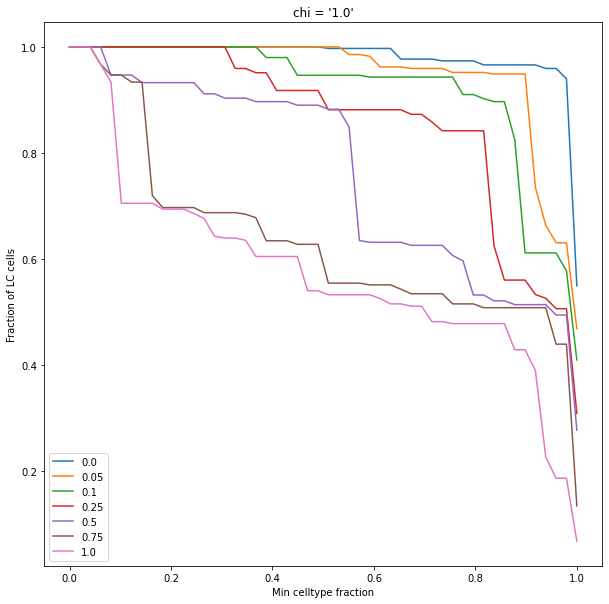

In [48]:
xs = np.linspace(0,1)

plt.figure(figsize=(10,10))
for chi in reneel_params:
    j = joint_marginal(HB_node_df, chi, "celltype", True)
    c = j[j.celltype.str.startswith("LC") & ~j.celltype.str.startswith("LCNO")].groupby("celltype").agg({"celltype_count":"first","celltype_fraction":"max"}).sort_values("celltype_fraction")

    plt.plot(xs, [c[c.celltype_fraction >= x]["celltype_count"].sum() / c.celltype_count.sum() for x in xs], label=chi)
    plt.title(f"{chi = }")
    plt.xlabel("Min celltype fraction")
    plt.ylabel("Fraction of LC cells")
plt.legend()

ValueError: Unknown format code 'f' for object of type 'str'

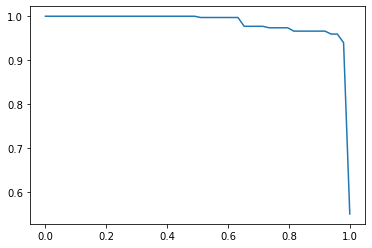

In [46]:
# plt.scatter(c.celltype_count, c.celltype_fraction)
# plt.xscale("log")
plt.plot(xs, [c[c.celltype_fraction >= x]["celltype_count"].sum() / c.celltype_count.sum() for x in xs])
plt.title(f"{chi = }")
plt.xlabel("Min celltype fraction")
plt.ylabel("Fraction of LC cells")

# Cluster Coherence

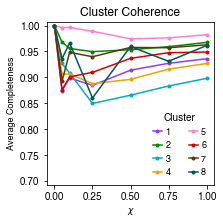

In [42]:
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

coherences = []
for chi in reneel_params[1:]:
    j = joint_marginal(HB_node_df, "0.0", chi, True)
    j[f"coherence_{chi}"] = j["0.0_fraction"] * j[f"{chi}_fraction"]
    coherences.append(j.groupby("0.0").agg({f"coherence_{chi}":"sum"}).sort_index())
df = pd.concat(coherences, axis=1)
df["coherence_0.0"] = 1
df = df[[f"coherence_{x}" for x in reneel_params]]

plt.figure(figsize=(3,3))
for c in range(1,9):
    plt.plot([float(x) for x in reneel_params], df.loc[c],
             color=color_mapper(c, "0.0"),
             marker=".", label=str(c))
plt.legend(title="Cluster",
           fontsize=9, ncol=2,
           handlelength=1, handletextpad=0.4,
           frameon=False,
           loc="lower right")
plt.xlabel(r"$\chi$",fontsize=9)
plt.ylabel("Average Completeness", fontsize=9)
dy = plt.gca().get_ylim()[1] - 1
plt.ylim(0.7 - dy, 1 + dy)
plt.title("Cluster Coherence", fontsize=12)

for ext in ["png","pdf"]:
    plt.savefig(os.path.join(figure_dir, "Supplement", f"cluster-coherence.{ext}"), bbox_inches="tight")

# Cluster Heterogeneity
Showing how clustering compares to cell type, and maybe how hierarchical the clustering is

In [45]:
types_of_interest = ['MC61', 'ER4d', 'LC13', 'KCab-c', 'LC10', 'KCab-m', 'ER3w', 'ER3m']

In [46]:
counts = {c: HB_node_df[c].value_counts() for c in reneel_params + ['celltype']}

In [47]:
def heterogeneity_score(df, col1, col2):
    """Compute the heterogeneity of `col1` with respect to `col2`.
    The idea is, each column represents a different labeling of, e.g. nodes in a graph.
    This computes the conditional entropy of the distribution of `col2` given `col1`,
    and returns 
    """
    total_counts = {c: df.value_counts(c) for c in [col1, col2]}
    
    joint = df.value_counts([col1, col2]).reset_index().rename(columns={0:'count'})
    joint['col1_count'] = total_counts[col1][joint[col1]].values
    p = joint['count'] / joint['col1_count']
    joint['conditional_entropy'] = -p * np.log2(p)
    res = joint.groupby(col1).agg({'conditional_entropy': 'sum', col2:'count'})
    res['heterogeneity'] = res['conditional_entropy'].where(res['conditional_entropy'] == 0,
                                                            res['conditional_entropy'] / np.log2(res[col2]))
#     res['heterogeneity'] = res['conditional_entropy'] / np.log2(res[col2])
#     res['heterogeneity'].fillna(0, inplace=True)
    res = res.rename(columns={col2:'n_'+col2})
    res[col1+'_count'] = total_counts[col1][res.index]
    return res

In [48]:
cluster_celltype_het_dfs = {chi: heterogeneity_score(HB_node_df, chi, 'celltype')
                            for chi in reneel_params}
cluster_typegroup_het_dfs = {chi: heterogeneity_score(HB_node_df, chi, "type_group")
                             for chi in reneel_params}
cluster_hierarchy_het_dfs = {chi1: heterogeneity_score(HB_node_df, chi1, chi2)
                             for chi1, chi2 in zip(reneel_params[1:], reneel_params[:-1])}

## Shuffle Trials
Let's generate several shuffled versions of the data, to see how "not-random" our heterogeneity scores are.

In [49]:
n_trials = 100
shuffle_csv = os.path.join(analysis_dir, f"shuffled-labels-{n_trials}.csv")
recompute_shuffle = not os.path.exists(shuffle_csv)

if recompute_shuffle:
    log_msg(f"No shuffle data found. Computing {n_trials} shuffle trials")
    shuffled_labels_df = pd.DataFrame(HB_node_df[reneel_params + ['celltype', 'type_group']])

    
    for t in range(n_trials):
        for c in reneel_params + ['celltype', 'type_group']:
            shuffled_labels_df[c + '_shuffle_' + str(t)] = np.random.permutation(shuffled_labels_df[c].values)
    log_msg(f"Saving to {shuffle_csv}")
    shuffled_labels_df.to_csv(shuffle_csv)
else:
    log_msg(f"Found shuffle data in {shuffle_csv}")
    shuffled_labels_df = pd.read_csv(shuffle_csv, index_col=0)
    
del shuffle_csv

2022 11 15 11:13:27  Found shuffle data in analysis/v1.1/shuffled-labels-100.csv


In [50]:
log_msg("Computing stats for shuffled data (cluster size, type entropy, type completeness)")
identifiers = ["celltype", "type_group"]

shuf_stats = {chi:[] for chi in reneel_params}
shuffle_stats = {i: {chi: [] for chi in reneel_params} for i in identifiers}
for chi in reneel_params:
    for identifier in identifiers:
        for trial in range(n_trials):
            id_shuf = identifier+"_shuffle_"+str(trial)
            j_shuf = joint_marginal(shuffled_labels_df, chi, id_shuf)
            j_shuf[id_shuf+"_completeness"] = j_shuf["joint_count"] ** 2 / (j_shuf[chi + "_count"] * j_shuf[id_shuf+"_count"])
            p_cond = j_shuf["joint_count"] / j_shuf[chi+"_count"]
            j_shuf[id_shuf+"_entropy"] = -p_cond * np.log2(p_cond)
            j_shuf = j_shuf.groupby(chi).agg({chi+"_count":"first", id_shuf+"_completeness":"sum", id_shuf+"_entropy":"sum"})
            j_shuf = j_shuf.rename(columns={chi+"_count":"count", id_shuf+"_completeness":"shuffle_completeness", id_shuf+"_entropy":"shuffle_entropy"})
#             shuf_stats[chi].append(j_shuf)
            shuffle_stats[identifier][chi].append(j_shuf)
#         shuf_stats[chi] = pd.concat(shuf_stats[chi], ignore_index=True)
        shuffle_stats[identifier][chi] = pd.concat(shuffle_stats[identifier][chi], ignore_index=True)

2022 11 15 11:13:30  Computing stats for shuffled data (cluster size, type entropy, type completeness)


In [51]:
identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from finest to coarsest)
shuf_stats = shuffle_stats[identifier]

In [52]:
js = {}
for chi in reneel_params:
    j = joint_marginal(HB_node_df, chi, identifier, True)
#     j = j[j[f"{chi}_count"] >= thresh]
#     j[f"{identifier}_completeness"] = j["joint_count"] ** 2 / (j[f"{chi}_count"] * j[f"{identifier}_count"])
    j[f"{identifier}_completeness"] = j[f"{chi}_fraction"] * j[f"{identifier}_fraction"]
#     p_cond = j["joint_count"] / j[f"{chi}_count"]
    p_cond = j[f"{chi}_fraction"]
    j[f"{identifier}_entropy"] = -p_cond * np.log2(p_cond)
    j = j.groupby(chi).agg({f"{chi}_count":"first", f"{identifier}_completeness":"sum", f"{identifier}_entropy":"sum"})
    js[chi] = j

In [53]:
cluster_threshold = 2
shuf_means = {chi: m[m["count"] >= cluster_threshold].groupby("count").agg(["mean","std"]) for chi, m in shuf_stats.items()}
for df in shuf_means.values():
    for s in ["entropy", "completeness"]:
        df[f"shuffle_{s}","mean_plus3"] = df[f"shuffle_{s}","mean"] + 3 * df[f"shuffle_{s}", "std"]
        df[f"shuffle_{s}","mean_minus3"] = df[f"shuffle_{s}","mean"] - 3 * df[f"shuffle_{s}", "std"]
        if s == "completeness":
            df["shuffle_completeness", "mean_minus3"] = np.maximum(df["shuffle_completeness", "mean_minus3"], 0)

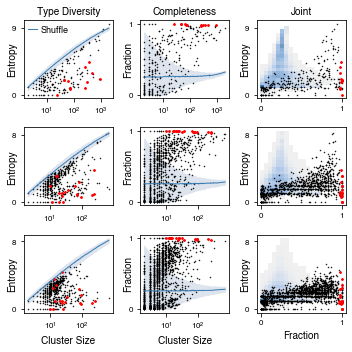

In [55]:
# with plt.rc_context({"pdf.fonttype": 42, "ps.fonttype":42}):
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

n_plots = 3
color_mode = "static"
# chi = "0.0"
figure_chis = ["0.25", "0.5", "0.75"]
# figure_chis = reneel_params
filename = f"heterogeneity-completeness-{identifier}-grouped"
# identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from coarsest to finest)
cluster_threshold = 2
mark_clusters = True
mark_subclusters = False

size_thresh = 10
comp_thresh = 0.97
clusters_to_mark = {x: j[(j[f"{identifier}_completeness"] >= comp_thresh) & (j[x+"_count"] >= size_thresh)].index.tolist() for x,j in js.items()}

# clusters_to_mark = {"0.25": [54],
#                     "0.5": [388]}
# clusters_to_mark = {}
#                     "0.75": HB_node_df[HB_node_df["0.25"] == 54]["0.75"].unique().tolist() + HB_node_df[HB_node_df["0.5"] == 388]["0.5"].unique().tolist()}
# secondary_mark = {"0.5": [*HB_node_df[HB_node_df["0.25"] == c]["0.5"].unique().tolist() for c in clusters_to_mark["0.25"]],
#                   "0.75": [*HB_node_df[HB_node_df["0.5"] == c]["0.75"].unique().tolist() for c in clusters_to_mark["0.5"]]}


scatter_kw = {"shuffle": dict(marker=".", alpha=0.1),
              "original": dict(marker=".", color="black", s=1),
              "mark": dict(marker="o", alpha=1.0, s=3, color="red"),
              "secondary": dict(marker="s", alpha=1.0, s=25)}

scatter_palette = cc.kr #cc.dimgray[len(cc.dimgray)//8::-1]

label_kw = dict(fontsize=10)
title_kw = dict(fontsize=10)
ticks_kw = dict(fontsize=8)
legend_kw = dict(fontsize=9, frameon=False, handlelength=1, handletextpad=0.4, borderpad=0)

fs = []
fig_scale = 5/3

clusters_to_check = {chi: [] for chi in figure_chis}
comp_check_thresh = 0.97
# js = {}

plt.figure(figsize=(3 * fig_scale, fig_scale * len(figure_chis)), tight_layout="tight") # 
# plt.figure(figsize=(5,5), tight_layout="tight")
for i, chi in enumerate(figure_chis):
    # reducing chart junk
    hetticks = [0,8]
    if chi == "0.25":
        hetticks[1] = 9
    comticks = [0,1]
    
    sizeticks = [10, 100]
    if chi == "0.25":
        sizeticks += [1000]
    
    mss = shuf_stats[chi]
    mss = mss[mss["count"] >= cluster_threshold]
    mss_mean = mss.groupby("count").agg(["mean", "std"])
    mss_mean["shuffle_entropy","mean_plus3"] = mss_mean["shuffle_entropy","mean"] + 3 * mss_mean["shuffle_entropy","std"]
    mss_mean["shuffle_entropy","mean_minus3"] = mss_mean["shuffle_entropy","mean"] - 3 * mss_mean["shuffle_entropy","std"]
    mss_mean["shuffle_completeness","mean_plus3"] = mss_mean["shuffle_completeness","mean"] + 3 * mss_mean["shuffle_completeness","std"]
    mss_mean["shuffle_completeness","mean_minus3"] = mss_mean["shuffle_completeness","mean"] - 3 * mss_mean["shuffle_completeness","std"]
    mss_mean["shuffle_completeness","mean_minus3"] = np.maximum(mss_mean["shuffle_completeness","mean_minus3"], 0)
    mss_mean = mss_mean.sort_index()
    
    j = js[chi]
    j = j[j[f"{chi}_count"] >= cluster_threshold]
    clusters_to_check[chi] = j[j[f"{identifier}_completeness"] > comp_check_thresh].index.tolist()
    
    plot_num = 0
    if color_mode == "static":
        scatter_kw["shuffle"]["color"] = "lightblue"
        scatter_kw["original"]["color"] = "black"
    else:
        scatter_kw["shuffle"]["c"] = np.log(mss["count"])
        scatter_kw["shuffle"]["cmap"] = ListedColormap(cc.blues)
        scatter_kw["original"]["c"] = np.log(j[chi+"_count"])
        scatter_kw["original"]["cmap"] = ListedColormap(cc.kr)
    
    ####################################################
    # Plot heterogeneity (conditional entropy)
    ####################################################
    plot_num += 1
    axent = plt.subplot(len(figure_chis), n_plots, n_plots * i + plot_num)
    if i == 0:
#         plt.title("Celltype Heterogeneity", **title_kw)
        plt.title("Type Diversity", **title_kw)
    plt.fill_between(mss_mean.index,
                     mss_mean["shuffle_entropy", "mean_minus3"], mss_mean["shuffle_entropy", "mean_plus3"],
                     color=cc.blues[25])
    plt.plot(mss_mean.index, mss_mean["shuffle_entropy", "mean"], c=cc.blues[-1], linewidth=1, label="Shuffle")
    
    jse = j.groupby([f"{chi}_count", f"{identifier}_entropy"]).agg("count").reset_index()
    plt.scatter(jse[f"{chi}_count"], jse[f"{identifier}_entropy"],
                **scatter_kw["original"])
    if mark_clusters and chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], chi+"_count"],
                    j.loc[clusters_to_mark[chi], identifier+"_entropy"],
                    **scatter_kw["mark"])
    plt.xscale("log")
    if i+1 == len(figure_chis):
        plt.xlabel("Cluster Size", **label_kw)
    plt.ylabel("Entropy", labelpad=-5, **label_kw)
    plt.xticks(sizeticks, **ticks_kw)
    plt.yticks(hetticks, **ticks_kw)
    if i == 0:
        plt.legend(**legend_kw)
    
    ####################################################
    # Plot completeness (average celltype fraction)
    ####################################################
    plot_num += 1
    axcom = plt.subplot(len(figure_chis), n_plots, n_plots *i + plot_num)
    if i == 0:
        plt.title("Completeness", **title_kw)  # "Celltype Completeness"
    plt.fill_between(mss_mean.index,
                     mss_mean["shuffle_completeness", "mean_minus3"], mss_mean["shuffle_completeness", "mean_plus3"],
                     color=cc.blues[25])
    plt.plot(mss_mean.index, mss_mean["shuffle_completeness", "mean"], c=cc.blues[-1], linewidth=1, label="Shuffle")
    jsc = j.groupby([f"{chi}_count", f"{identifier}_completeness"]).agg("count").reset_index()
    plt.scatter(jsc[f"{chi}_count"], jsc[f"{identifier}_completeness"],
                **scatter_kw["original"])
    if mark_clusters and chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], chi+"_count"],
                    j.loc[clusters_to_mark[chi], identifier+"_completeness"],
                    **scatter_kw["mark"])
    plt.xscale("log")
    if i+1 == len(figure_chis):
        plt.xlabel("Cluster Size", **label_kw)
    plt.ylabel("Fraction", labelpad=-5, **label_kw)
    plt.xticks(sizeticks, **ticks_kw)
    plt.yticks(comticks, **ticks_kw)
#     plt.legend(**legend_kw)
    
    ####################################################
    # Plot heterogeneity vs. completeness
    ####################################################
    plot_num += 1
    axcombo = plt.subplot(len(figure_chis), n_plots, n_plots * i + plot_num)
    if i == 0:
        plt.title("Joint", **title_kw)  # "Heterogeneity vs Completeness"
    plt.hist2d(mss["shuffle_completeness"], mss["shuffle_entropy"],
               bins=20,
               cmap=ListedColormap(cc.blues),
               cmin=1,)
    jce = j.groupby([f"{identifier}_completeness", f"{identifier}_entropy"]).agg({f"{chi}_count":"count"}).reset_index()
    plt.scatter(jce[f"{identifier}_completeness"], jce[f"{identifier}_entropy"],
                **scatter_kw["original"])
    if mark_clusters and chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], identifier+"_completeness"],
                    j.loc[clusters_to_mark[chi], identifier+"_entropy"],
                    **scatter_kw["mark"],)
    if i+1 == len(figure_chis):
        plt.xlabel("Fraction", **label_kw)
    plt.ylabel("Entropy", labelpad=-5, **label_kw)
    plt.xticks(comticks, **ticks_kw)
    plt.yticks(hetticks, **ticks_kw)
    axcombo.set_ylim(axent.get_ylim())
    axcombo.set_xlim(axcom.get_ylim())
    
    # make a bunch of bokeh figures for interactive working
    h0 = figure(title="Het. and Comp w/shuffle")
#     h0.scatter(x="shuffle_completeness", y="shuffle_entropy",
#                color=log_cmap("count", palette=cc.blues, low=1, high=mss["count"].max()),
#                source=mss)
    h0.scatter(x=identifier+"_completeness", y=identifier+"_entropy",
               color=log_cmap(chi+"_count", palette=cc.CET_L4, low=1, high=j[chi+"_count"].max()),
               source=j)
    j = j[j[chi+"_count"] >= 10]
    mss = mss[mss["count"] >= 10]
#     f = figure(title="Heterogeneity", x_axis_type="log")
#     f.scatter(x=chi+"_count", y=identifier+"_entropy", color="red", source=j)
#     f.xaxis.axis_label="Cluster Size"
#     f.yaxis.axis_label="Entropy (bits)"
#     f.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Entropy":"@"+identifier+"_entropy"}))
    
#     g = figure(title="Completeness", x_axis_type="log")
#     g.scatter(x=chi+"_count", y=identifier+"_completeness", color="red", source=j)
#     g.xaxis.axis_label="Cluster Size"
#     g.yaxis.axis_label="Completeness"
#     g.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Completeness":"@"+identifier+"_completeness"}))
    
    h = figure(title="Het. and Comp., chi = "+chi)
    h.scatter(x=identifier+"_completeness", y=identifier+"_entropy", source=j)
    h.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Completeness":"@"+identifier+"_completeness", "Entropy":"@"+identifier+"_entropy"}))
    h.xaxis.axis_label="Completeness"
    h.yaxis.axis_label="Entropy (bits)"
#     fs.append([f,g,h])
    fs.append([h0, h])

with plt.rc_context({"pdf.fonttype": 42, "ps.fonttype":42}):
    for ext in ["png", "pdf"]:
        plt.savefig(os.path.join(figure_dir, "4 Celltype Het Comp", f"{filename}.{ext}"), bbox_inches="tight")

In [56]:
# show(gridplot(fs, plot_width=400, plot_height=400))

In [57]:
# chi = "0.25"
# j = js["0.25"]
thresholds = list(range(2,101))
dfcom = pd.DataFrame({chi: [j[j[f"{chi}_count"] >= thresh][f"{identifier}_completeness"].mean() for thresh in thresholds] for chi, j in js.items()},
                     index=thresholds)
stdcom = pd.DataFrame({chi: [j[j[f"{chi}_count"] >= thresh][f"{identifier}_completeness"].std() for thresh in thresholds] for chi, j in js.items()},
                     index=thresholds)
dfent = pd.DataFrame({chi: [j[j[f"{chi}_count"] >= thresh][f"{identifier}_entropy"].mean() for thresh in thresholds] for chi, j in js.items()},
                     index=thresholds)
stdent = pd.DataFrame({chi: [j[j[f"{chi}_count"] >= thresh][f"{identifier}_entropy"].std() for thresh in thresholds] for chi, j in js.items()},
                     index=thresholds)
# dfshufcom = pd.DataFrame({chi: [s[s["count"] >= thresh]["shuffle_completeness"].mean() for thresh in thresholds] for chi, s in shuf_stats.items()},
#                          index=thresholds)
# dfshufent = pd.DataFrame({chi: [s[s["count"] >= thresh]["shuffle_entropy"].mean() for thresh in thresholds] for chi, s in shuf_stats.items()},
#                          index=thresholds)

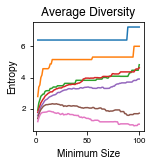

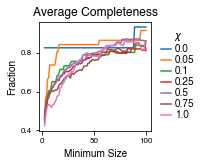

In [58]:


cm = dict(zip(reneel_params, bokeh.palettes.Category20_20[::2]))
cmstd = dict(zip(reneel_params, bokeh.palettes.Category20_20[1::2]))
# for df, dfs, name in zip([dfent, dfcom], [dfshufent, dfshufcom], ["Entropy", "Completeness"]):
for df, std, name, ylabel in zip([dfent, dfcom], [stdcom, stdent], ["Diversity", "Completeness"], ["Entropy", "Fraction"]):
    plt.figure(figsize=(2,2))
#     plt.suptitle(f"Cluster {name}")
#     plt.subplot(1,2,1)
    plt.title(f"Average {name}", fontsize=12)
    for chi in reneel_params:
        plt.plot(df.index, df[chi], label=f"{float(chi)}", c=cm[chi])
#         if name == "Entropy":
#             plt.fill_between(std.index, df[chi] - 3 * std[chi], df[chi] + 3 * std[chi],
#                              color=cmstd[chi], alpha=0.5)
#         plt.plot(dfs.index, dfs[chi], c=cm[chi], linestyle="dashed")
    plt.xlabel("Minimum Size", fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    if name == "Completeness":
        plt.legend(title=r"$\chi$", fontsize=10,
                   handlelength=1, handletextpad=0.4,
                   labelspacing=0.1,
                   frameon=False,
                   loc="upper left", bbox_to_anchor=(1.01, 1))
    for ext in ["png", "pdf"]:
        plt.savefig(os.path.join(figure_dir, "Supplement", f"average-{name}.{ext}"), bbox_inches="tight")
    
#     plt.subplot(1,2,2)
#     for t, c in zip(df.index, cc.kr[50::2]):
#         plt.plot([float(c) for c in reneel_params], df.loc[t], color=c)
#     plt.xlabel("Chi")
    
#     for ext in ["png", "eps"]:
#         plt.savefig(os.path.join(figure_dir, "Supplement", f"average-{name}.{ext}"), bbox_inches="tight")

In [ ]:

rs = {}
for i, chi in enumerate(reneel_params):
    s = shuf_stats[chi].groupby("count").agg({"shuffle_completeness": ["mean", "std"], "shuffle_entropy": ["mean","std"]})
    s.columns = ["_".join(c).strip() for c in s.columns]
    d = js[chi]
    r = d.merge(s, left_on=f"{chi}_count", right_index=True)
    r["z_entropy"] = (r[f"{identifier}_entropy"] - r[("shuffle_entropy_mean")]) / r[("shuffle_entropy_std")]
    r["z_completeness"] = (r[f"{identifier}_completeness"] - r[("shuffle_completeness_mean")]) / r[("shuffle_completeness_std")]
    rs[chi] = r

In [ ]:
z_thresh = 3
# size_thresh = 10
size_thresholds = [1,2,10,20,100]
# summary = dict(chi=[], thresh=[], n_clusters=[], sig_ent=[], sig_com=[])
summary = []
for size_thresh in size_thresholds:
    for chi, r in rs.items():
        size_criterion = (r[f"{chi}_count"] >= size_thresh)
        n_clusters = size_criterion.sum()
        n_original = r.shape[0]
#         print(f"{chi = }, {size_thresh = } yields {n_clusters} clusters")
        sig_ent = (size_criterion & (r.z_entropy <= -z_thresh)).sum() / size_criterion.sum()
        sig_com = (size_criterion & (r.z_completeness >= z_thresh)).sum() / size_criterion.sum()
#         print(f"  {sig_ent = :0.2%}")
#         print(f"  {sig_com = :0.2%}")

        summary.append([float(chi), n_original, size_thresh, n_clusters, sig_ent, sig_com])
df = pd.DataFrame(summary, columns=["Chi", "Original Clusters", "Size Threshold", "Thresh Clusters", "sig_ent", "sig_com"])
display(df)

In [ ]:
# with pd.option_context("display.max_rows", 400):
#     display(js["0.25"])

size_thresh = 20
comp_thresh = 0.97
ent_thresh = 1.0

for x, j in js.items():
#     display(j[(j[x+"_count"] >= size_thresh) & ((j.celltype_completeness > comp_thresh) | (j.celltype_entropy < ent_thresh))])
    display(j[(j[x+"_count"] >= size_thresh) & (j.celltype_entropy < ent_thresh)])

In [37]:
def move_to_end(original, to_end):
    """Move the elements in the intersection of `original` and `to_end` to the end of `original`
    and return that list."""
    return [x for x in original if x not in to_end] + [x for x in to_end if x in original]

def move_after(items, x, y):
    """Return list `items` with x moved to just after y.
    If either one is not in the list or x == y, return the original list"""
    if x not in items or y not in items or x == y:
        return items
    ix = items.index(x)
    new = items[:ix] + items[ix+1:]
    iy = new.index(y)
    new.insert(iy+1, x)
    return new

def move_before(items, x, y):
    """Return list `items` with x moved to just before y.
    If either one is not in the list or x == y, return the original list"""
    if x not in items or y not in items or x == y:
        return items
    ix = items.index(x)
    new = items[:ix] + items[ix+1:]
    iy = new.index(y)
    new.insert(iy, x)
    return new

size_thresh = 10
comp_thresh = 0.97
focus_clusters = {x: j[(j[f"{identifier}_completeness"] >= comp_thresh) & (j[x+"_count"] >= size_thresh)].index.tolist() for x,j in js.items()}
focus_clusters["0.25"] = move_to_end(focus_clusters["0.25"], [68, 89, 251])
focus_clusters["0.5"] = move_to_end(focus_clusters["0.5"], [])
# focus_clusters["0.5"].append(388)

# chis = ["0.25","0.5","0.75"]
chis = reneel_params
t = HB_node_df.value_counts(chis).reset_index().rename(columns={0:"joint_count"})
for chi in chis:
    s = HB_node_df.value_counts(chi)
    s.name = chi+"_count"
    t = t.merge(s, left_on=chi, right_index=True)
    t[chi+"_fraction"] = t["joint_count"] / t[chi+"_count"]
crit = np.ones(t.shape[0], dtype=bool)
for chi in chis:
    crit = crit & t[chi].isin(focus_clusters[chi])
core_clusters = t[crit]
core_dict = {chi: core_clusters[chi].unique().tolist() for chi in chis}

reorder_before = {"0.25": [(54, 258), (68, 251)],
                  "0.5": [(182, 1072)],
                  "0.75": [(2602, 654), (163, 1206)]}
reorder_after = {"0.5": [(963, 1051), (189, 1051), (1072, 963), (784, 955)]}

graphs = {}
ugraphs = {}
for chi in chis:
    log_msg(f"Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = {chi}")
    V,E = reduced_graph(HB_node_df[HB_node_df[chi].isin(focus_clusters[chi])],
                        HB_edge_df[HB_edge_df[chi+"pre"].isin(focus_clusters[chi]) & HB_edge_df[chi+"post"].isin(focus_clusters[chi])],
                        chi,
                        suffixes=["pre","post"],
                        u_col="pre", v_col="post",
                        weight_col="weight",
                        undirected=False)
    _, Eu = reduced_graph(HB_node_df[HB_node_df[chi].isin(focus_clusters[chi])],
                          u_edge_df[u_edge_df[chi+"_1"].isin(focus_clusters[chi]) & u_edge_df[chi+"_2"].isin(focus_clusters[chi])],
                          chi,
                          suffixes=["_1", "_2"])
#     V = V.loc[focus_clusters[chi]]
    V["color"] = [color_mapper(c, chi) for c in V.index]
    V["celltypes"] = [", ".join(HB_node_df[HB_node_df[chi] == c]["celltype"].unique()) for c in V.index]
    V["type_groups"] = [", ".join(HB_node_df[HB_node_df[chi] == c]["type_group"].unique()) for c in V.index]
    
    d = pd.concat([V.type_groups.str.contains("E?R|FB"),
                   V.type_groups.str.contains("MB|KC"),
                   V.type_groups.str.contains("VLP|SAD"),
                   V.type_groups.str.contains("S?P|v|LN"),
                   V.type_groups.str.contains("ATL")],
                  axis=1,
                  ignore_index=True).rename(columns=dict(enumerate(["CX", "MB", "Vis","SNP", "INP"])))
    order = d.sort_values(d.columns.tolist()).index.tolist()
    for tup in reorder_before.get(chi, []):
        order = move_before(order, *tup)
    for tup in reorder_after.get(chi, []):
        order = move_after(order, *tup)
    V = V.loc[order]
    
#     df = neuron_roi_adj[neuron_roi_adj[chi].isin(focus_clusters[chi])].groupby([chi, "roi"]).agg({"total_synapses":"sum"}).reset_index()
#     df = df.pivot_table(index=chi, columns="roi", values="total_synapses", fill_value=0)
#     for missing_roi in np.setdiff1d(roi_depth_1, df.columns):
#         df[missing_roi] = 0
#     df = df[roi_depth_1]
#     rois = {c: ", ".join(accumulate_clusters(df.loc[c] / df.loc[c].sum(), threshold=0.95)) for c in df.index}
#     V = V.merge(pd.DataFrame.from_dict(rois, orient="index", columns=["rois"]), left_index=True, right_index=True)
    
#     Vs[chi] = V
#     Es[chi] = E
    graphs[chi] = (V,E)
    ugraphs[chi] = (V, Eu)
    
    

2022 11 14 18:40:28  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 0.0
2022 11 14 18:40:34  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 0.05
2022 11 14 18:40:35  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 0.1
2022 11 14 18:40:36  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 0.25
2022 11 14 18:40:37  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 0.5
2022 11 14 18:40:38  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 0.75
2022 11 14 18:40:38  Computing reduced graphs (directed and undirected) for high-completeness clusters, chi = 1.0


In [38]:
def display_type(t):
    """Map a celltype or type_group `t` to a display type.
    For example, every Kenyon cell subtypes will map to "KC" """
    if t in ["LC", "ER", "ExR", ]: # removed "PVLP", "AVLP", "LPLC", "PAM", "FC", "FB"
        return t
    for s in ["KC", "PFN", "FB"]: # removed: "EPG", "PFN", "PFG", "LH",
        if t.startswith(s):
            return s
    return "Other"

HB_node_df["display_type"] = HB_node_df["type_group"].apply(display_type)

In [39]:
palette = np.array(cc.glasbey_dark + cc.glasbey + cc.glasbey_light)
palette[555] = "#888800"  # This was some obnoxiously bright yellow so I decided to tone it down
override = {"0.25": {54:cc.glasbey[0]},
            "0.5": {388: cc.glasbey_bw[41]}}
celltype_colormap = dict(zip(HB_node_df.celltype.unique(), cycle(palette)))
celltype_colormap["None"] = "gray"
typegroup_colormap = dict(zip(HB_node_df.type_group.unique(), cycle(palette)))
typegroup_colormap["None"] = "gray"
typegroup_colormap["LC"] = cc.glasbey[51]

def color_mapper(val, chi="0.0", colors=palette, override=override):
    if chi == "celltype":
        default = celltype_colormap.get(val, "gray")
        return override.get("celltype", {}).get(val, default)
    elif chi == "type_group":
        default = typegroup_colormap.get(val, "gray")
        return override.get("type_group", {}).get(val, default)
    else:  # chi is one of the reneel params
        default = colors[val % len(colors)]
        if val <= 0:
            return "gray"
        return override.get(chi, {}).get(val, default)

In [128]:
# for chi, (V,E) in graphs.items():
annotate_core = False
only_core = False

base_dim = 600
graph_radius = 1.3
pad_right = 0 #0.35 * graph_radius
pad_left = 0
xr = (-(graph_radius + pad_left), graph_radius + pad_right)
yr = (-graph_radius, graph_radius)
pw, ph = int(base_dim * (2 * graph_radius + pad_left + pad_right) // (2 * graph_radius)), base_dim

overlay = "display_type"
set_color = overlay != "display_type"
include_piechart = True

# primary_type = HB_node_df.value_counts(["type_group", "celltype"]).reset_index().groupby("type_group").agg({"celltype":"first"})
# color_override = {"type_group": {"KC": typegroup_colormap["KCg"],
#                                  "LH": typegroup_colormap["LHAD"]}}
desired_order = ["ER", "ExR", "FB", "PFN", "LC", "KC", "Other"]

graph_type = "undirected"

leg_labels = []
# for i, chi in enumerate(["0.25","0.5","0.75"]):
for i, chi in enumerate(reneel_params):
    
    if graph_type == "directed":
        V,E = graphs[chi]
        u_col=chi+"pre"
        v_col=chi+"post"
    else:
        V,E = ugraphs[chi]
        u_col = chi+"_1"
        v_col = chi+"_2"
    if only_core:
        V,E = subgraph(V,E, core_clusters[chi].unique(), u_col=u_col, v_col=v_col)
    n_nodes = V.shape[0]
    r_max = 2 * np.pi / n_nodes / 3
    
    edge_kw = {"directed": dict(edge_draw_function=lambda p,q: low_k_arc(p,q, offset=3, k=5),
                                
                                edge_start_col=chi+"pre",
                                edge_end_col=chi+"post",
                                edge_weight_col="weighted_density",
                                scale_loops_by="weighted_density",
                                edge_color_mode="start"),
               "undirected": dict(edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1, p, q, k=5),
                                  edge_start_col=chi+"_1",
                                  edge_end_col=chi+"_2",
                                  edge_weight_col="weighted_density",
                                  scale_loops_by="weighted_density")}
    
    g = draw_graph(V,E, layout="circle",
                   **edge_kw[graph_type],
                   loop_draw_function=lambda p,q: outer_loop_circle([0,0], p, r_max/10),
                   scale_nodes_by="n_nodes", node_scale_mode="linear",
                   r_max_factor=0.41,
                   node_fill_by="color", node_fill_mode="custom",
#                    node_line_by="color", node_line_mode="custom", node_line_width=5,
                   loop_k=6, loop_r=r_max/1.5
                   )
    
    f = figure(title=None,
               x_range=xr, y_range=yr,
               width=pw, height=ph,
               border_fill_color=None,
               outline_line_color=None,
               outline_line_width=0,
               background_fill_color=None)
    f.renderers.append(g)
    f.add_tools(TapTool(), HoverTool(tooltips={"Cluster":f"@index (@{overlay})",
                                               "# Cells":"@n_nodes",
#                                                "ROIs":"@rois",
                                               "Type Overview":"@type_groups",
                                               "Celltypes":"@celltypes"}))
    
    # Let's annotate the "core" clusters:
    if annotate_core:
        for c in core_clusters[chi].unique():
            v_c = np.array(g.layout_provider.graph_layout[c])
            p = 1.25 * v_c
            q = 1.1 * v_c
            arrow = Arrow(end=NormalHead(fill_color="black", size=10),
                          x_start=p[0], x_end=q[0],
                          y_start=p[1], y_end=q[1],
                          line_color="black", line_width=2)
            f.add_layout(arrow)
    
    if include_piechart:
        pc = piechart_overlay_df(g, HB_node_df, chi, overlay, set_color=set_color)
        if not set_color:
            tmp = HB_node_df.value_counts(["display_type", "type_group"]).reset_index()
            tmp = tmp[tmp["type_group"] != "None"]
            tmp = tmp.groupby("display_type").agg({"type_group":"first"})
            tmp["color"] = tmp["type_group"].apply(lambda t: color_mapper(t, "type_group"))
            pc = pc.merge(tmp["color"], left_on="display_type", right_index=True)
        wedge_kw = dict(x="x", y="y", radius="radius",
                        start_angle="start_angle", end_angle="end_angle",
                        fill_color="color", line_color=None, alpha=1.0,
                        source=pc)
        if True: #i == 0:  # turn off legend for now
            wedge_kw["legend_group"] = overlay
        f.wedge(**wedge_kw)
    
        if True: #i == 0:
            def order_key(li):
                t = li.label["value"]
                if t in desired_order:
                    return desired_order.index(t)
                return len(desired_order)
            f.legend.items = list(sorted(f.legend.items, key=order_key))
            f.legend.label_text_font_size = "20pt"
            f.legend.title = "Cell Type"
            f.legend.title_text_font_size = "20pt"
            f.legend.title_text_font_style = "normal"
        
    f.axis.visible = False
    f.grid.visible = False
    
        
    # now, let's add a tiny graph showing the next level of core clusters
#     if i+1 < len(chis):
#         chi2 = chis[i+1]
#         print("chi2 = ",chi2)
#         V2, E2 = graphs[chi2]
#         V2 = V2[V2.index.isin(core_clusters[chi2])]
# #         E2 = E2[E2[chi2+"pre"].isin(core_clusters[chi2]) & E2[chi2+"post"].isin(core_clusters[chi2])]
#         E2 = pd.DataFrame(columns=E2.columns)  # let's not bother drawing edges
#         subgraph_layout = {}
#         main_nodes = g.node_renderer.data_source.to_df().set_index("index")
#         for c_main in core_clusters[chi].unique():
#             center = g.layout_provider.graph_layout[c_main]
#             radius = main_nodes.loc[c_main, "radius"]
#             child_cs = core_clusters[core_clusters[chi] == c_main][chi2].unique()
#             child_layout = circle_layout(V2.loc[child_cs], center, 0.85 * radius)
#             subgraph_layout.update(child_layout)
#         g2 = draw_graph(V2, E2, layout=subgraph_layout,
#                         edge_start_col=chi2+"pre", edge_end_col=chi2+"post", edge_weight_col="weighted_density",
#                         scale_nodes_by="n_nodes", node_scale_mode="linear",
#                         node_fill_by="color", node_fill_mode="custom",)
#         subgraph_layout = pd.DataFrame.from_dict(subgraph_layout, orient="index", columns=["x","y"])
#         eff = g2.node_renderer.data_source.to_df().merge(subgraph_layout, left_on="index", right_index=True)
#         f.circle(x="x", y="y", radius="radius", fill_color="color", line_color=None, source=eff)
    show(f)

## Celltype entropy w.r.t. cluster ID across values of chi
To identify potentially interesting celltypes, we can plot the entropy of cell type labels within one cell type across values of chi, and look for celltypes that start clustered, but split up. This is a quick way to identify potentially interesting cell types at a glance

,conditional_entropy,n_0.0,heterogeneity,celltype_count
celltype,,,,
DNp16,0.0,1,0.0,12
Delta7,0.0,1,0.0,42
EL,0.0,1,0.0,18
EPG,0.0,1,0.0,46
ER1_a,0.0,1,0.0,16
...,...,...,...,...
vDeltaI,0.0,1,0.0,25
vDeltaJ,0.0,1,0.0,11
vDeltaK,0.0,1,0.0,46


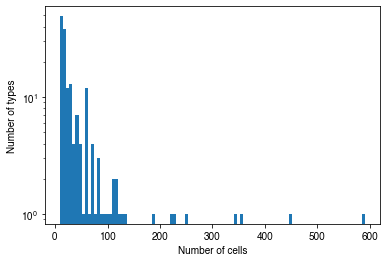

In [59]:
# heterogeneity_score(HB_node_df, 'celltype', '0.0')
celltype_threshold = 10
type_counts = HB_node_df.value_counts("celltype")
valid_types = [t for t in type_counts.index if type_counts[t] >= celltype_threshold and t != "None"]
plt.hist(HB_node_df[HB_node_df.celltype.isin(valid_types)].value_counts("celltype"), bins=100)
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Number of types")

display(heterogeneity_score(HB_node_df[HB_node_df.celltype.isin(valid_types)], 'celltype', '0.0'))

In [60]:
identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from coarsest to finest)

celltype_threshold = 10
type_counts = HB_node_df.value_counts(identifier)
valid_types = [t for t in type_counts.index if type_counts[t] >= celltype_threshold and t != "None"]
valid_HB_nodes = HB_node_df[HB_node_df[identifier].isin(valid_types)]
valid_counts = valid_HB_nodes.value_counts(identifier)

print(f"""Selecting {identifier}-identified celltypes (i.e. not "None") with at least {celltype_threshold} cells.""")

celltype_heterogeneity_df = pd.DataFrame(index=valid_types)
for chi in reneel_params:
    df = heterogeneity_score(valid_HB_nodes, identifier, chi)
    celltype_heterogeneity_df['conditional_entropy_' + chi] = df['conditional_entropy']
celltype_heterogeneity_df = celltype_heterogeneity_df.T
# celltype_heterogeneity_df['chi'] = [float(c) for c in reneel_params]
celltype_heterogeneity_df

Selecting celltype-identified celltypes (i.e. not "None") with at least 10 cells.


,KCg-m,LC10,KCab-m,MC61,KCab-c,LC12,KCab-s,LC17,LC9,KCa'b'-ap2,...,WED092,FB4E,PS289,LT57,TuBu08,ER4m,WED143,WED030,ER3d_d,ER3d_b
conditional_entropy_0.0,0.000000,0.041280,0.000000,0.051290,0.000000,0.000000,0.000000,0.000000,0.111241,0.000000,...,1.095795,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
conditional_entropy_0.05,0.000000,0.530492,0.000000,0.000000,0.000000,0.000000,0.000000,0.085743,0.434986,0.000000,...,1.322179,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
conditional_entropy_0.1,0.000000,0.585820,0.000000,2.031978,0.000000,0.000000,0.000000,0.085743,0.759565,0.000000,...,1.348588,0.0,0.000000,0.000000,0.721928,0.0,0.000000,0.721928,0.0,0.0
conditional_entropy_0.25,0.000000,1.211408,0.000000,2.795295,0.000000,0.000000,0.000000,0.085743,0.803136,0.000000,...,1.095795,0.0,0.439497,1.494919,1.521928,0.0,0.000000,0.000000,0.0,0.0
conditional_entropy_0.5,0.018044,2.849147,0.240216,4.392811,0.140548,0.000000,0.000000,0.085743,1.217908,0.161321,...,1.095795,0.0,0.845351,1.867634,2.721928,0.0,0.000000,0.721928,0.0,0.0
conditional_entropy_0.75,0.018044,4.766340,1.212392,5.200981,0.979869,0.040972,0.000000,0.085743,2.324303,0.201840,...,1.095795,0.0,1.936260,2.550341,2.721928,0.0,0.000000,0.721928,0.0,0.0
conditional_entropy_1.0,0.291086,6.016829,2.608060,5.806528,3.605710,0.569088,0.506241,0.085743,3.060879,0.340365,...,1.095795,0.0,2.222192,3.027169,2.921928,0.0,0.881291,1.846439,0.0,0.0


# Celltype Completeness and Homogeneity
Let's do the celltype/cluster fraction graph, but as two separate graphs.

One will show "celltype completeness", which is what fraction of the cells of that type belong to a cluster, on average (so, a cell type that is completely contained within one cluster will get a score of 1.0. If half the cells belong to each of two clusters, it would get a score of 0.5. If one third belong to one cluster and two thirds belong to another, it gets a score of 5/9). This works out to the sum of the squares of the fractions of the cell type in each cluster.

The other will show "celltype heterogeneity", which is what fraction of a cluster is represented by a given celltype, on average.

In [41]:
types_of_interest = ['MC61', 'ER4d', 'LC13', 'KCab-c', 'LC10', 'KCab-m', 'ER3w', 'ER3m', 'LC17'] + ['LC12',
 'ER4d',
 'LC16',
 'LC13',
 'KCg-m',
 'ER3w',
 'LC6',
 'KCab-p',
 'LC17',
 'LPLC2']

In [42]:
identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from finest to coarsest)
identifier_counts = HB_node_df.value_counts(identifier)
identifier_counts.name= identifier+"_count"
# chi = "0.0"

# homcoms = []
homogeneity = pd.DataFrame(index=identifier_counts.index) #(index=HB_node_df[identifier].unique())
completeness = pd.DataFrame(index=identifier_counts.index) #(index=HB_node_df[identifier].unique())
for chi in reneel_params:
#     joint = HB_node_df.value_counts([identifier, chi]).reset_index().rename(columns={0:"joint"})
#     joint[identifier+"_count"] = HB_node_df.value_counts(identifier)[joint[identifier].values].values
#     joint[chi+"_count"] = HB_node_df.value_counts(chi)[joint[chi].values].values
#     joint["p_joint"] = joint["joint"] / joint["joint"].sum()
#     joint["p_"+identifier] = joint["joint"] / joint[identifier+"_count"]
#     joint["p_"+chi] = joint["joint"] / joint[chi+"_count"]
#     joint["p_"+identifier+"_2"] = joint["p_"+identifier] ** 2
#     joint["p_"+chi+"_2"] = joint["p_"+chi] * joint["p_"+identifier]
#     homcom = joint.groupby(identifier).agg({"p_"+identifier+"_2":"sum", "p_"+chi+"_2":"sum"})
    j = joint_marginal(HB_node_df, identifier, chi, True)
    j[f"p_{identifier}_2"] = j[f"{identifier}_fraction"] ** 2
    j[f"p_{identifier}_p_{chi}"] = j[f"{identifier}_fraction"] * j[f"{chi}_fraction"]
    homcom = j.groupby(identifier).agg({f"p_{identifier}_2": "sum", f"p_{identifier}_p_{chi}":"sum"})
#     homcom = homcom.rename(columns={"p_"+identifier+"_2":"completeness_"+chi, "p_"+chi+"_2":"homogeneity_"+chi})
#     homcoms.append(homcom)
#     homogeneity[chi] = homcom["p_"+chi+"_2"]
#     completeness[chi] = homcom["p_"+identifier+"_2"]
    homogeneity[chi] = homcom[f"p_{identifier}_p_{chi}"]
    completeness[chi] = homcom[f"p_{identifier}_2"]
# homogeneity_and_completeness = pd.concat(homcoms, axis=1)

Text(0, 0.5, 'Interestingness')

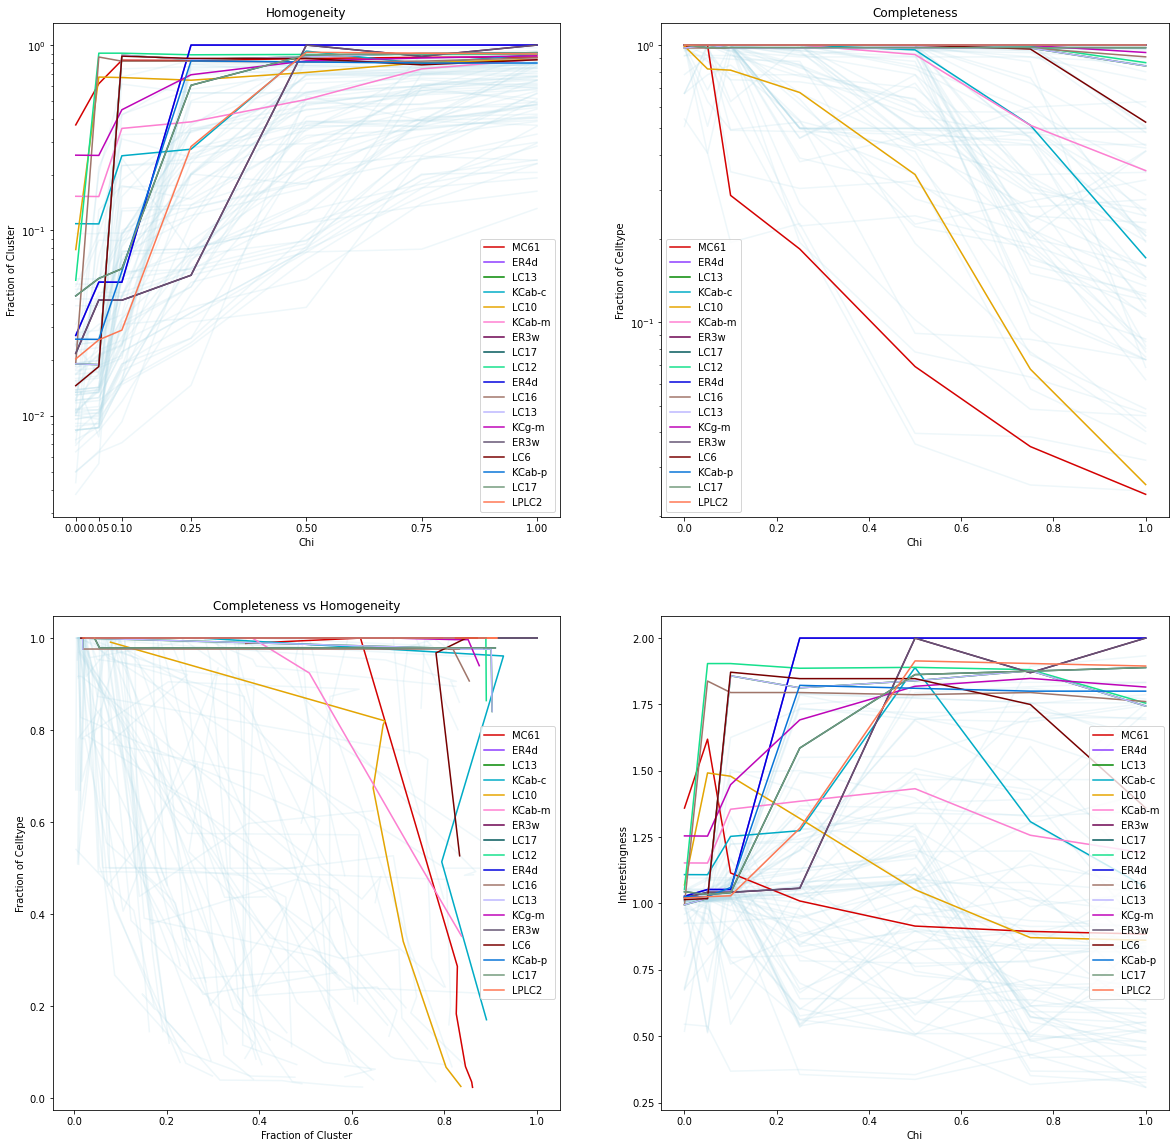

In [43]:
cluster_threshold = 20

hom = homogeneity.loc[identifier_counts >= cluster_threshold]
com = completeness.loc[identifier_counts >= cluster_threshold]

hom = hom[hom.index != "None"]
com = com[com.index != "None"]

interest = hom + com

total_interest = pd.DataFrame(interest.sum(axis=1), columns=["interest"])
id_counts = HB_node_df.value_counts(identifier)
id_counts.name = "count"
total_interest = total_interest.merge(id_counts, left_index=True, right_index=True)

x = hom[reneel_params]
x["zero"] = 0
x = x[["zero"] + reneel_params + ["zero"]]
y = com[reneel_params]
y["zero"] = 0
y = y[["zero"] + reneel_params + ["zero"]]

total_interest["rotation"] = np.abs(np.sum(x.values[:,:-1] * y.values[:,1:] - x.values[:, 1:] * y.values[:,:-1], axis=1) / 2)
# total_interest = total_interest.merge(interest["rotation"], left_index=True, right_index=True)
# total_interest.sort_values("rotation", ascending=False)
# total_interest

rpf = [float(c) for c in reneel_params]

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.title("Homogeneity")
plt.plot(rpf, hom.values.T, color="lightblue", alpha=0.2)
plt.xlabel("Chi")
plt.ylabel("Fraction of Cluster")
for t, color in zip(types_of_interest, palette):
    if t in hom.index:
        plt.plot(rpf, hom.loc[t], color=color, label=t)
plt.legend()
plt.yscale("log")
plt.xticks(rpf)

plt.subplot(2,2,2)
plt.title("Completeness")
plt.plot(rpf, com.values.T, color="lightblue", alpha=0.2)
plt.xlabel("Chi")
plt.ylabel("Fraction of Celltype")
for t, color in zip(types_of_interest, palette):
    if t in hom.index:
        plt.plot(rpf, com.loc[t], color=color, label=t)
plt.legend()
plt.yscale("log")

plt.subplot(2,2,3)
plt.title("Completeness vs Homogeneity")
plt.plot(hom.values.T, com.values.T, color="lightblue", alpha=0.2)
for t, color in zip(types_of_interest, palette):
    if t in hom.index:
        plt.plot(hom.loc[t], com.loc[t], color=color, label=t)
plt.legend()
plt.xlabel("Fraction of Cluster")
plt.ylabel("Fraction of Celltype")
# plt.xscale("log")
# plt.yscale("log")

plt.subplot(2,2,4)
plt.plot(rpf, interest.values.T, color="lightblue", alpha=0.2)
for t, color in zip(types_of_interest, palette):
    if t in hom.index:
        plt.plot(rpf, interest.loc[t], color=color, label=t)
plt.legend()
plt.xlabel("Chi")
plt.ylabel("Interestingness")

In [61]:
from matplotlib.colors import ListedColormap

types_of_interest = ["hDeltaK", 'MC61', 'PFGs']  # "LC10", "KCab-c", "ER4d",
# types_of_interest = HB_node_df[HB_node_df.celltype.str.startswith("PFN")]["celltype"].unique().tolist()

cluster_threshold = 10

hom = homogeneity.loc[identifier_counts >= cluster_threshold]
com = completeness.loc[identifier_counts >= cluster_threshold]

hom = hom[hom.index != "None"]
com = com[com.index != "None"]

interest = hom + com

total_interest = pd.DataFrame(interest.sum(axis=1), columns=["interest"])
id_counts = HB_node_df.value_counts(identifier)
id_counts.name = "count"
total_interest = total_interest.merge(id_counts, left_index=True, right_index=True)

x = hom[reneel_params]
x["zero"] = 0
x = x[["zero"] + reneel_params + ["zero"]]
y = com[reneel_params]
y["zero"] = 0
y = y[["zero"] + reneel_params + ["zero"]]

total_interest["rotation"] = np.abs(np.sum(x.values[:,:-1] * y.values[:,1:] - x.values[:, 1:] * y.values[:,:-1], axis=1) / 2)
# total_interest = total_interest.merge(interest["rotation"], left_index=True, right_index=True)
# total_interest.sort_values("rotation", ascending=False)
# total_interest

rpf = [float(c) for c in reneel_params]

plt.figure(figsize=(2.5,2.5))
plt.title("Cell type partitions", fontsize=10)
plt.plot(hom.values.T, com.values.T,
         linewidth=0.5,
         color="lightblue", alpha=0.2)
plt.plot()
# plt.scatter(hom.values, com.values,
#             c=[float(chi) for chi in reneel_params], cmap=ListedColormap(cc.blues))

# for t, color in zip(types_of_interest, palette):
# for t, p in zip(types_of_interest, [cc.kr, cc.kg, cc.kb, cc.CET_CBL4[:230]]):
for t, p in zip(types_of_interest, cycle([cc.kr, cc.kg, cc.kb, cc.CET_CBL4[:230]])):
    color = p[-1]
    if t in hom.index:
        if t == "hDeltaK":
            lab = r"h$\Delta$K"
        else:
            lab = t
        plt.plot(hom.loc[t], com.loc[t], c=color, label=lab)
#         plt.plot(hom.loc[t], com.loc[t], c=[float(chi) for chi in reneel_params], cmap="Reds")
        plt.scatter(hom.loc[t], com.loc[t],
                    s=20, zorder=1000,
                    c=[float(chi) for chi in reneel_params], cmap=ListedColormap(list(reversed(p))),
                    alpha=1.0)
# legend_kw = dict(fontsize=9, frameon=False, handlelength=1, handletextpad=0.4, borderpad=0)
plt.legend(loc="lower left", fontsize=9, frameon=False, handlelength=1, handletextpad=0.4, borderpad=0)
# plt.colorbar(label="Chi")
plt.xlabel("Fraction of Cluster", fontsize=10, labelpad=-6)
plt.ylabel("Fraction of Celltype", fontsize=10, labelpad=-6)
plt.xticks([0,1], fontsize=9)
plt.yticks([0,1], fontsize=9)

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

with plt.rc_context({"pdf.fonttype": 42, "ps.fonttype":42}):
    for ext in ["png", "pdf"]:
        plt.savefig(os.path.join(figure_dir, "5 Celltype Change", f"celltype_completeness_vs_homogeneity.{ext}"))

NameError: name 'homogeneity' is not defined

In [46]:
top10types = total_interest.sort_values("rotation", ascending=False).index.tolist()[:10]
top20types = total_interest.sort_values("rotation", ascending=False).index.tolist()[:20]

top10types

['KCab-c',
 'LLPC2a',
 'LC10',
 'LC6',
 'LC29',
 'LLPC2b',
 'MC61',
 'Li13',
 'LC27',
 'PFNa']

# Looking downstream of MC61 and others
I want to get a sense of how the neighbors of MC61 cells (and the clusters they belong to) end up clustering.

Likewise for the top 10 most interesting cell types (as measured by the "rotation" score, computed in the previous section)

In [47]:
print(top20types)

['KCab-c', 'LLPC2a', 'LC10', 'LC6', 'LC29', 'LLPC2b', 'MC61', 'Li13', 'LC27', 'PFNa', 'LC9', 'LPC1', 'hDeltaK', 'LC13', 'FR1', 'ER4m', 'ER3d_d', 'ER3d_b', 'ER3p_a', 'ER3m']


In [ ]:
with pd.option_context("display.max_rows", 100):
    display(total_interest.sort_values("interest", ascending=False))

In [48]:
# collect all cell types that appear in a cluster with MC61 cells
def neighbor_celltypes(ct, chis=reneel_params, df=HB_node_df):
    """Given a cell type `ct` and a list `chis` of chi values, return a list
    of all unique cell types which appear in a cluster containing cells of type `ct`"""
    selected = HB_node_df[HB_node_df["celltype"] == ct]
    types = []
    for chi in chis:
        clusters = selected[chi].unique()
        new_types = HB_node_df[HB_node_df[chi].isin(clusters)].celltype.unique()
        types = np.union1d(types, new_types)
    return types

In [49]:
# from bokeh.models import Arc, Legend
n_types = 10
block_size = 20
interest_by = "rotation"  # options are "interest" and "rotation"
types_to_show = total_interest.sort_values(interest_by, ascending=False).index.tolist()[:n_types]
types_to_show = ["MC61", "hDeltaK"]
# types_to_show = ["Delta7", "hDeltaJ", "hDeltaC", "hDeltaK"] #+ total_interest[total_interest.index.str.contains("vDelta")].index.tolist()

# chi = "0.5"
# ctoi = "MC61"  # ctoi stands for "cell type of interest"
# ctoi_chi = {"MC61": "0.5"}
node_threshold = 10
ctoi_chi = {ct: ["0.5", "0.75", "1.0"] for ct in types_to_show}
ctoi_mm = {ct: (0.8, 1.0) for ct in types_to_show}
# ctoi_mm["hDeltaK"] = (0.0, 1.0)
ctoi_mm.update({"hDeltaK": (0.0, 1.0),
                "hDeltaC": (0.5, 1.0),
                "hDeltaJ": (0.5, 1.0),
                "LC9": (0.5, 1.0),
                "vDeltaE": (0.0, 1.0),
                "vDeltaA_a": (0.0, 1.0)})
fs = []
renders = {ct: {x: {} for x in ["0.5", "0.75", "1.0"]} for ct in types_to_show}
ct_cms = {ct: {} for ct in types_to_show}
for ctindex, (ctoi, chis) in enumerate(ctoi_chi.items()):
    MCClusters = HB_node_df[HB_node_df.celltype == ctoi][chi].unique()


    ct_cm = dict(zip(neighbor_celltypes(ctoi, reneel_params[2:]), cc.glasbey))
    ct_override = {ctoi: "black",
                   **dict(zip(['AOTU032', 'AOTU036', 'AOTU038', 'AOTU039', 'AOTU046', 'AOTU047',
                      'AOTU054', 'AOTU055', 'AOTU056', 'AOTU057', 'AOTU058'], cc.kb[-1::-5])),
                   **dict(zip(['TuBu01', 'TuBu02', 'TuBu03', 'TuBu04', 'TuBu05', 'TuBu06',
                      'TuBu07', 'TuBu08', 'TuBu09', 'TuBu10'], cc.kr[-1::-5]))}
#                    **{x: "#ff0000" for x in ['AOTU032', 'AOTU036', 'AOTU038', 'AOTU039', 'AOTU046', 'AOTU047',
#                       'AOTU054', 'AOTU055', 'AOTU056', 'AOTU057', 'AOTU058']},
#                    **{x: "#00ff00" for x in ['TuBu01', 'TuBu02', 'TuBu03', 'TuBu04', 'TuBu05', 'TuBu06',
#                       'TuBu07', 'TuBu08', 'TuBu09', 'TuBu10']}}
    ct_cm.update(ct_override)
    ct_cms[ctoi] = ct_cm


    data_space_radius = 1.2
    r_arc = 1.045
    es = 1 # edge scale

    mc_min, mc_max = ctoi_mm[ctoi]

#     log_msg("Generating graphs for nodes in clusters between", mc_min,"and", mc_max, " cells")
    log_msg(f"({ctindex:4})[{ctoi:8}] Generating graphs for nodes in clusters between {mc_min:0.0%} and {mc_max:0.0%} {ctoi} cells")

    # chi = "0.25"
    # celltype = "MC61"  # another good option is LC10. This is actually determined by ctoi, up above
    # for chi in reneel_params:
    ctoi_fs = []
    
#     plt.plot(hom.loc[t], com.loc[t], c=color, label=t)
    f = figure(title=f"{ctoi} Homogeneity and Completeness",
               x_range=(0,1),
               y_range=(0,1))
    f.line(x=hom.loc[ctoi], y=com.loc[ctoi])
    f.xaxis.axis_label = "Homogeneity"
    f.yaxis.axis_label = "Completeness"
    ctoi_fs.append(f)
    
    for chi in chis:
    # clusters = [891, 814, 893, 933, 894, 961, 935, 623]
    # clusters = jm[jm["cluster_fraction"] > 0.9]["0.5"].tolist()
        MCClusters = HB_node_df[HB_node_df.celltype == ctoi][chi].unique()
        jm = joint_marginal(HB_node_df, chi, "celltype")
        jm["cluster_fraction"] = jm["joint_count"] / jm[chi+"_count"]
        clusters = jm[(jm.celltype == ctoi) & (jm.cluster_fraction >= mc_min) & (jm.cluster_fraction <= mc_max)][chi].tolist()
#         print("Chi", chi)
#         print("Graph of clusters", clusters)
        

        nodes = pd.DataFrame(HB_node_df[HB_node_df[chi].isin(clusters)]).sort_values([chi, "celltype"])[list_of_params]
        nodes["color"] = [color_mapper(c, chi) for c in nodes[chi]]
        nodes["type_color"] = [ct_cm.get(t, "gray") for t in nodes["celltype"]]
        n_nodes = nodes.shape[0]
        if n_nodes < node_threshold:
            ctoi_fs.append(None)
            log_msg("|",f"Chi = {chi}: {n_nodes} nodes found. Skipping this one")
            continue
#         print(n_nodes, "nodes")
        
#         log_msg("|",f"Total nodes: {n_nodes}")
#         log_msg("|","Chi =",chi,":",clusters)
        log_msg("|",f"Chi = {chi}: {n_nodes} nodes, clusters:",clusters)
        
        nodes["theta"] = np.linspace(0, 2*np.pi, n_nodes+1)[:-1]
        nodes["x"] = np.cos(nodes["theta"])
        nodes["y"] = np.sin(nodes["theta"])
        n_mc = jm[jm[chi].isin(clusters) & (jm.celltype == ctoi)].joint_count.sum()
        n_total = (HB_node_df.celltype == ctoi).sum()
        
        r_theta = 2 * np.pi / n_nodes / 3  # radius of the nodes, in radians
        
        log_msg("|","|",f"{n_mc / n_total:6.2%} {ctoi} coverage ({n_mc} / {n_total})")
        log_msg("|","|","Cell types in this graph:", nodes["celltype"].unique())
        
        renders[ctoi][chi]["coverage"] = n_mc / n_total
        renders[ctoi][chi]["clusters"] = clusters

    #     edges = u_edge_df[(u_edge_df[chi+"_1"].isin(clusters)) & (u_edge_df[chi+"_2"].isin(clusters))]
    #     edges = edges.merge(HB_node_df[["celltype"]], left_on="node1", right_index=True)
    #     edges = edges.merge(HB_node_df[["celltype"]], left_on="node2", right_index=True, suffixes=["_1","_2"])
        edges = HB_edge_df[HB_edge_df[chi+"pre"].isin(clusters) & HB_edge_df[chi+"post"].isin(clusters)]
    #     edges = edges.merge(HB_node_df[["celltype"]], left_on="pre", right_index=True)
    #     edges = edges.merge(HB_node_df[["celltype"]], left_on="node2", right_index=True, suffixes=["_1","_2"])

        # for c in [891, 814]:
    #     g,ts = circle_layout_graph(nodes,
    #                                edges,
    #                                node_data_cols=["celltype","instance"],
    #                                scale_nodes_by="instance", node_scale_mode="ones",
    #                                node_line_by="color", node_line_color_mode="custom", node_line_width=0,
    # #                                node_fill_by="celltype", node_fill_color_mode="categorical",
    #                                node_fill_by="type_color", node_fill_color_mode="custom",
    #                                edge_scale=es,
    #                                hover_tooltips={"cluster, ID": "@{"+chi+"}, @index",
    #                                                "celltype": "@celltype"},
    #                                circle_k=4)

        g = draw_graph(nodes, edges,
                       layout="circle",
                       edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1, p, q, k=5),
                       edge_start_col="pre", edge_end_col="post", edge_weight_col="weight",
                       node_fill_by="type_color", node_fill_mode="custom",
                       node_line_width=0,
                       edge_color_mode="start")

        f = figure(title=f"{ctoi}, chi = {chi} ({n_nodes} nodes, {n_mc/n_total:6.2%} coverage)",
#                    title=ctoi + ", chi = " + chi, #"Reduced graph, chi = "+chi,
                   match_aspect=True,
                   x_range=(-data_space_radius, data_space_radius),
                   y_range=(-data_space_radius, data_space_radius),
                   width=600, height=600,
                   border_fill_color=None,
                   outline_line_color=None)
        f.renderers.append(g)

    #     tmp = pd.DataFrame(g.node_renderer.data_source.data).groupby(chi).agg({"theta":["min", "max"]})
    #     tmp = pd.DataFrame(g.node_renderer.data_source.data)
    #     tmp = tmp.merge(pd.DataFrame.from_dict(g.layout_provider.graph_layout, orient="index", columns=["x","y"]), left_on="index", right_index=True)
    #     tmp["theta"] = np.arccos(tmp["x"])
    #     tmp["theta"] = tmp["theta"].where(tmp["y"] >= 0, 2 * np.pi - tmp["theta"])
        tmp = nodes.groupby(chi).agg({"theta":["min", "max"]})
        tmp["thetas"] = [np.linspace(tmp.loc[c,("theta","min")] - r_theta, tmp.loc[c,("theta","max")] + r_theta).tolist() for c in tmp.index]
        tmp["xs"] = [r_arc * np.cos(l) for l in tmp["thetas"]]
        tmp["ys"] = [r_arc * np.sin(l) for l in tmp["thetas"]]
        # tmp[("theta","min")] = tmp[("theta","min")] - r_theta
        # tmp[("theta","max")] = tmp[("theta","max")] + r_theta
        tmp["color"] = [color_mapper(c, chi) for c in tmp.index]

    #     glyph = Arc(x=0, y=0, radius=1,
    #                 start_angle="theta_min", end_angle="theta_max",
    #                 line_color="color_", line_width=10,)
        #             source=tmp)
        # glyph = Arc(x=0, y=0, radius=250, start_angle=0, end_angle=2 * np.pi, line_width=10, radius_units="screen")
        # f.add_glyph(ColumnDataSource(tmp), glyph)
        # l = np.linspace(0, 2 * np.pi)
        # f.line(x=np.cos(l), y=np.sin(l), line_width=10, line_color="red")
    #     lines = []
        # for c in tmp.index:
        #     l = np.linspace(tmp.loc[c,("theta","min")] - r_theta, tmp.loc[c,("theta","max")] + r_theta)
        # #     f.line(x=np.cos(l), y=np.sin(l),
        # #            line_width=10, line_color=color_mapper(c, chi))
        #     f.line(x=r_arc * np.cos(l), y=r_arc * np.sin(l),
        #            line_width=10, line_color=color_mapper(c, chi))
        f.multi_line(xs="xs_", ys="ys_", line_width=10, line_color="color_", source=tmp)

        # add an annotation with the value of chi
        f.add_layout(Label(text="Chi = " + chi, x=-1, y=1, text_font_size="10pt"))
        # leg = Legend(items=[(str(c), [l]) for c,l in zip(tmp.index, lines)], title="Title")
        # f.add_layout(leg, "right")
    #     f.add_tools(*ts)
        f.add_tools(TapTool(), HoverTool(tooltips={"cluster, ID": "@{"+chi+"}, @index", "Cell Type": "@celltype"}))
        f.grid.visible=False
        f.axis.visible=False
#         show(f)
        ctoi_fs.append(f)
    fs.append(ctoi_fs)
    print()
    
# Swap the colors for PFGs and FB6A for figure purposes.
ct_cms["hDeltaK"]["PFGs"], ct_cms["hDeltaK"]["ExR3"] = ct_cms["hDeltaK"]["ExR3"], ct_cms["hDeltaK"]["PFGs"]

# save(gridplot(fs, plot_width=500, plot_height=500),
#      filename=os.path.join(figure_dir, f"interesting-celltypes-{interest_by}.html"),
#      title=f"Top {len(types_to_show)} most interesting cell types (you won't believe number 7!)")
# n_blocks = int(np.ceil(n_types / block_size))
# for b in range(n_blocks):
#     fname = os.path.join(figure_dir, "celltypes", f"interesting-celltypes-{interest_by}-{b*block_size}-{(b+1)*block_size}.html")
#     log_msg(f"Saving {fname}")
#     save(gridplot(fs[b*block_size:(b+1)*block_size],plot_width=500, plot_height=500),
#          filename=fname,
#          title=f"Top {b*block_size+1} to {(b+1)*block_size} most interesting cell types (you won't believe number {np.random.randint(b*block_size+1, (b+1)*block_size+2)}!)")

2022 11 14 18:48:00  (   0)[MC61    ] Generating graphs for nodes in clusters between 80% and 100% MC61 cells
2022 11 14 18:48:00  | Chi = 0.5: 293 nodes, clusters: [623, 893, 961, 891, 935, 814, 933, 894, 861, 919, 858, 968, 783, 938, 915, 857, 996, 992, 936, 967, 998, 1451]
2022 11 14 18:48:00  | | 74.57% MC61 coverage (258 / 346)
2022 11 14 18:48:00  | | Cell types in this graph: ['AOTU055' 'AOTU056' 'MC61' 'TuBu07' 'TuBu09' 'TuBu10' 'TuTuB_a' 'TuBu08'
 'TuBu01' 'TuBu06']
2022 11 14 18:48:01  | Chi = 0.75: 287 nodes, clusters: [2002, 2092, 1949, 2051, 1898, 1904, 1792, 2046, 1895, 1902, 2045, 2011, 1896, 2055, 1761, 2056, 2003, 2108, 1906, 2053, 2150, 2152, 2009, 1950, 2052, 2047, 2159, 2147, 2151, 1952, 1954, 1953, 1894, 1899, 1809, 3072, 2161, 2160, 1951, 2001, 2004]
2022 11 14 18:48:01  | | 74.86% MC61 coverage (259 / 346)
2022 11 14 18:48:01  | | Cell types in this graph: ['MC61' 'TuBu09' 'AOTU046' 'TuBu08' 'TuBu01' 'TuBu10' 'AOTU054' 'TuBu07'
 'TuBu06']
2022 11 14 18:48:03  | C

In [50]:
chi, ct = "1.0", "hDeltaK"
reduce_by = chi
clusters = renders[ct][chi]["clusters"]
# HB_node_df[HB_node_df[chi].isin(clusters)],
V,E = reduced_graph(HB_node_df[HB_node_df.celltype.isin(["hDeltaK", "PFGs"])],
                    u_edge_df.merge(HB_node_df.celltype, left_on="node1", right_index=True).merge(HB_node_df.celltype, left_on="node2", right_index=True, suffixes=["_1","_2"]),
                    reduce_by,
                    suffixes=["_1","_2"])
V["color"] = [color_mapper(c, reduce_by) for c in V.index]

weight_col = "weighted_density"
# if reduce_by == "1.0":
#     n = V.shape[0]
#     V["x"] = 0
#     V["y"] = 0
#     thetas = np.linspace(0, 2*np.pi, n)[:-1]
#     V.loc[V.index != 2323, "x"] = np.cos(thetas)
#     V.loc[V.index != 2323, "y"] = np.sin(thetas)

#     t = 1/1.5
#     A = E.pivot_table(index=f"{chi}_1", columns=f"{chi}_2", values=weight_col, fill_value=0.0, )
#     A = A[list(sorted(A.columns))]
#     A = A.sort_index()
#     nodes = A.index.tolist()
#     W = A.values
#     W = W + W.T
#     for i in range(W.shape[0]):
#         W[i,i] = 0
#     # plt.imshow(W)
#     W = np.where(W > 0, np.exp(-W/t), W)
#     D = np.diag(W.sum(axis=0))
#     L = D - W
#     val, vec = eigh(L, D)
#     # vec[:,1:3]
#     layout = dict(zip(nodes, zip(vec[:,1], np.zeros_like(vec[:,1]))))

# xr = (vec[:,1:3].min(), vec[:,1:3].max())
# f = figure(x_range=xr, y_range=xr)

def move_to_end(original, to_end):
    """Move the elements in the intersection of `original` and `to_end` to the end of `original`
    and return that list."""
    return [x for x in original if x not in to_end] + [x for x in to_end if x in original]

def move_after(items, x, y):
    """Return list `items` with x moved to just after y.
    If either one is not in the list or x == y, return the original list"""
    if x not in items or y not in items or x == y:
        return items
    ix = items.index(x)
    new = items[:ix] + items[ix+1:]
    iy = new.index(y)
    new.insert(iy+1, x)
    return new

def move_before(items, x, y):
    """Return list `items` with x moved to just before y.
    If either one is not in the list or x == y, return the original list"""
    if x not in items or y not in items or x == y:
        return items
    ix = items.index(x)
    new = items[:ix] + items[ix+1:]
    iy = new.index(y)
    new.insert(iy, x)
    return new

node_order = V.index.tolist()
node_order = move_to_end(node_order, [1612, 2560])
befores = [(2001, 2560), (1812, 2266), (2893, 764), (1612, 2893)]
for t in befores:
    node_order = move_before(node_order, *t)
afters = [(2637, 764), (2224, 604), (1315, 2224), (2132, 1315), (1997, 2132),
          (2347, 1997), (2345, 2347), (2266, 2345), (1812, 2266), (2323, 1812),
          (2637, 2323), (764, 2637), (2893, 764), ( 2001, 604), (2560, 604)]
for t in afters:
    node_order = move_after(node_order, *t)
# node_order = node_order[:5] + node_order[13:8:-1] + node_order[5:9]


f = figure(x_range=(-1.25, 1.25), y_range=(-1.25, 1.25))

g = draw_graph(V.loc[node_order], E, layout="circle",# layout=layout,
               edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1.0, p, q, k=5),
               loop_draw_function=lambda p,q: outer_loop_circle([0,0], p, 0.05, k=6),
               edge_start_col=f"{reduce_by}_1", edge_end_col=f"{reduce_by}_2", edge_weight_col=weight_col,
               scale_nodes_by="n_nodes", node_scale_mode="linear",
               scale_edges_by=weight_col, scale_loops_by=weight_col,
               node_fill_by="color", node_fill_mode="custom",
               )
f.add_tools(TapTool(), HoverTool(tooltips={"Cluster":"@index", "Size":"@n_nodes"}))

f.renderers.append(g)
show(f)

In [51]:
chi, ct = "1.0", "hDeltaK"
clusters = renders[ct][chi]["clusters"]

f = figure(x_range=(-1.1, 1.1),
           y_range=(-0.4, 0.4),
           width=1100, height=400,
           outline_line_width=0, outline_line_color="white",
           background_fill_color=None,
           border_fill_color=None)
f.grid.visible = False
f.axis.visible = False

V = pd.DataFrame(HB_node_df[HB_node_df[chi].isin(clusters)]).sort_values(["1.0", "celltype"])
# E = HB_edge_df[HB_edge_df[f"{chi}pre"].isin(clusters) & HB_edge_df[f"{chi}post"].isin(clusters)]
E = u_edge_df[u_edge_df[f"{chi}_1"].isin(clusters) & u_edge_df[f"{chi}_2"].isin(clusters)]
E = E.merge(HB_node_df.celltype, left_on="node1", right_index=True).merge(HB_node_df.celltype, left_on="node2", right_index=True, suffixes=["_1","_2"])

# uncomment to include only hDK and PFGs
V = V[V.celltype.isin(["hDeltaK", "PFGs"])]
# E = E[E.celltypepre.isin(["hDeltaK", "PFGs"]) & E.celltypepost.isin(["hDeltaK", "PFGs"])]
E = E[E.celltype_1.isin(["hDeltaK", "PFGs"]) & E.celltype_2.isin(["hDeltaK", "PFGs"])]


V["color"] = [ct_cms[ct].get(t, "gray") for t in V.celltype]
V["cluster_color"] = [color_mapper(c, chi) for c in V[chi]]

n = V.shape[0]
h_crit = (V.celltype == "hDeltaK")
n_hDK = h_crit.sum()
p_crit = (V.celltype == "PFGs")
n_PFGs = p_crit.sum()
o_crit= (~V.celltype.isin(["hDeltaK", "PFGs"]))
n_other = o_crit.sum()
print(f"{n_hDK=}, {n_PFGs=}, {n_other=}, {sum([n_hDK, n_PFGs, n_other])=}")

# # bipartite layout with pfgs on top
V = V.sort_values(chi, key=lambda s: [node_order.index(c) for c in s], ascending=False)
V["x"], V["y"] = 0, 0
# V.loc[pfgs_loc.index, "x"] = (pfgs_order - pfgs_order.min()) * 2 / (pfgs_order.max() - pfgs_order.min()) - 1
# V.loc[pfgs_loc.index, "y"] = 1
# V.loc[V.celltype == "PFGs", "x"] = np.linspace(-1,1, n_PFGs)
V.loc[V.celltype == "PFGs", "y"] = 0.25

hdk_xs = np.linspace(-1, 1, n_hDK)
dx = hdk_xs[1] - hdk_xs[0]
V.loc[V.celltype == "hDeltaK", "x"] = hdk_xs
V.loc[V.celltype == "hDeltaK", "y"] = -0.25

if n_other > 0:
    V.loc[o_crit, "x"] = np.linspace(-0.5, 0.5, n_other)
    V.loc[o_crit, "y"] = -0.75


for c in clusters:
#     x_min = V.loc[(V.celltype == "hDeltaK") & (V[chi] == c), "x"].min()
#     x_max = V.loc[(V.celltype == "hDeltaK") & (V[chi] == c), "x"].max()
    x_mean = V.loc[(V.celltype == "hDeltaK") & (V[chi] == c), "x"].mean()
    crit = ((V.celltype == "PFGs") & (V[chi] == c))
    num = crit.sum()
    V.loc[crit, "x"] = np.linspace(x_mean - (num - 1) * dx/2, x_mean + (num-1) * dx/2, num)


# def draw_edge(p, q):
#     if p[0] * q[0] > 0:
#         # both points are on the left side of the circle
#         if p[1] > q[1]:
#             r = 1.0
#         else:
#             r = 1.1
#         return poincare_geodesic([0,0], r, p, q, k=5)
#     else:
#         return low_k_arc(p, q, offset=2)
def draw_edge(p, q):
    if p[1] == q[1]:
        # two nodes from the same part
        return low_k_arc(p, q, offset=0.85)
    return [p[0], q[0]], [p[1], q[1]]


    
g = draw_graph(V, E, layout="auto",
#                edge_draw_function=lambda p,q: low_k_arc(p, q, offset=5),
#                edge_draw_function=lambda p,q: poincare_geodesic([0,0],1,p,q),
               edge_draw_function=draw_edge,
               edge_weight_col="total_weight",
               edge_start_col="node1", edge_end_col="node2", e_max=3,
               node_fill_by="color", node_fill_mode="custom",
#                node_line_by="cluster_color", node_line_mode="custom", node_line_width=5,
#                edge_color_mode="start"
               )

r_node = g.node_renderer.data_source.data["radius"][0]
xs_top, xs_bot = [], []
ys_top, ys_bot = [], []
colors_top, colors_bot = [], []
for c in clusters:
    top_crit = ((V.celltype == "PFGs") & (V[chi] == c))
    bot_crit = ((V.celltype == "hDeltaK") & (V[chi] == c))
    n_top = top_crit.sum()
    n_bot = bot_crit.sum()
    if n_top > 0:
        xs_top.append([V.loc[top_crit, "x"].min() - r_node, V.loc[top_crit, "x"].max() + r_node])
        ys_top.append([0.25 + 2 * r_node] * 2)
        colors_top.append(color_mapper(c, chi))
    if n_bot > 0:
        xs_bot.append([V.loc[bot_crit, "x"].min() - r_node, V.loc[bot_crit, "x"].max() + r_node])
        ys_bot.append([-0.25 - 2 * r_node] * 2)
        colors_bot.append(color_mapper(c,chi))
f.multi_line(xs=xs_top, ys=ys_top, color=colors_top, line_width=10)
f.multi_line(xs=xs_bot, ys=ys_bot, color=colors_bot, line_width=10)


f.add_tools(TapTool(), HoverTool(tooltips={"Neuron":"@index","Cluster":"@{"+chi+"}", "Type":"@celltype"}))

f.renderers.append(g)

show(gridplot([f], ncols=1))

n_hDK=31, n_PFGs=18, n_other=0, sum([n_hDK, n_PFGs, n_other])=49


In [52]:
Vp = g.node_renderer.data_source.to_df()
# # Ep = g.edge_renderer.data_source.to_df()

# Vp = Vp[Vp["1.0"] == 2132]
Vp = pd.DataFrame(HB_node_df[HB_node_df["1.0"] == 2132])
Vp["color"] = [ct_cm[ct] for ct in Vp.celltype]
Ep = HB_edge_df[(HB_edge_df["1.0pre"] == 2132) & (HB_edge_df["1.0post"] == 2132)]

# Vp.set_index("index", inplace=True)
# Ep.set_index("index", inplace=True)

dx = 0.15
layout = {5813048755: (0, 0.25),  # The PFGs cell
          5813047626: (-dx, -0.25),  # Left hDK
          849059197: (dx, -0.25)
         }

display(Vp, Ep)

f = figure(x_range=(-0.4, 0.4),
           y_range=(-0.4, 0.4),
           width=400, height=400,
           outline_line_width=0, outline_line_color="white",
           background_fill_color=None,
           border_fill_color=None)
f.grid.visible = False
f.axis.visible = False

h = draw_graph(Vp, Ep, layout=layout,
#                edge_draw_function=lambda p,q: low_k_arc(p, q, offset=5),
#                edge_draw_function=lambda p,q: poincare_geodesic([0,0],1,p,q),
               edge_draw_function=lambda p,q: low_k_arc(p, q, offset=5),
               edge_weight_col="weight",
               edge_start_col="pre", edge_end_col="post", e_max=5,
               node_fill_by="color", node_fill_mode="custom",
#                node_line_by="cluster_color", node_line_mode="custom", node_line_width=5,
               edge_color_mode="start"
               )

f.add_tools(TapTool(), HoverTool(tooltips={"Neuron":"@index","Cluster":"@{"+chi+"}", "Type":"@celltype"}))

f.renderers.append(h)

show(gridplot([f], ncols=1))

,0.0,0.05,0.1,0.25,0.5,0.75,1.0,instance,celltype,pre,...,centroid_x_post,centroid_y_pre,centroid_y_post,centroid_z_pre,centroid_z_post,centroid_x,centroid_y,centroid_z,display_type,color
849059197,2,2,7,52,182,1534,2132,hDeltaK_03_C3,hDeltaK,273,...,26629.914894,21919.360000,22156.163121,15876.533333,17662.496454,27303.033613,22106.414566,17287.294118,Other,black
5813047626,2,2,7,52,182,1534,2132,hDeltaK_03_C3,hDeltaK,282,...,25108.229111,22164.366667,22221.247978,16917.766667,18384.924528,25607.305857,22210.143167,18098.494577,Other,black
5813048755,2,2,7,52,182,1534,2132,PFGs(PB10)_R3_C7,PFGs,458,...,28817.409336,20758.447059,21259.700180,16117.894118,16418.947935,28799.280374,21193.334891,16379.088785,Other,#d60000


,pre,post,weight,0.0pre,0.05pre,0.1pre,0.25pre,0.5pre,0.75pre,1.0pre,...,0.0post,0.05post,0.1post,0.25post,0.5post,0.75post,1.0post,celltypepost,instancepost,type_grouppost
1293106,849059197,5813048755,143,2,2,7,52,182,1534,2132,...,2,2,7,52,182,1534,2132,PFGs,PFGs(PB10)_R3_C7,PFGs
3207909,5813047626,5813048755,131,2,2,7,52,182,1534,2132,...,2,2,7,52,182,1534,2132,PFGs,PFGs(PB10)_R3_C7,PFGs
3207892,5813047626,849059197,4,2,2,7,52,182,1534,2132,...,2,2,7,52,182,1534,2132,hDeltaK,hDeltaK_03_C3,hDeltaK
3250461,5813048755,849059197,106,2,2,7,52,182,1534,2132,...,2,2,7,52,182,1534,2132,hDeltaK,hDeltaK_03_C3,hDeltaK
1293083,849059197,5813047626,8,2,2,7,52,182,1534,2132,...,2,2,7,52,182,1534,2132,hDeltaK,hDeltaK_03_C3,hDeltaK
3250463,5813048755,5813047626,140,2,2,7,52,182,1534,2132,...,2,2,7,52,182,1534,2132,hDeltaK,hDeltaK_03_C3,hDeltaK


In [102]:
chi, ct, cluster = "0.5", "hDeltaK", 182
clusters = renders[ct][chi]["clusters"]


# neurons = HB_node_df[HB_node_df["0.5"] == 182]
# all_edges = HB_edge_df[(HB_edge_df["0.5pre"] == 182) & (HB_edge_df["0.5post"] == 182)]

# V = neurons.groupby("celltype").agg({"instance":"count"})
# V["type_color"] = [ct_cms["hDeltaK"].get(t, "gray") for t in V.index]

# E = 



V = HB_node_df[HB_node_df[chi] == cluster].groupby("celltype").agg({"instance":"count"})
V["type_color"] = [ct_cms["hDeltaK"].get(t, "gray") for t in V.index]
V = V.loc[["FB6D", "ExR3", "PFGs", "hDeltaK", "FB6A", "FB6M"]]
E = HB_edge_df[(HB_edge_df[f"{chi}pre"] == cluster) & (HB_edge_df[f"{chi}post"] == cluster)]
E = E.groupby(["celltypepre","celltypepost"]).agg({"weight":"mean"}).reset_index()


V,E = reduced_graph(HB_node_df[HB_node_df[chi] == cluster], HB_edge_df, "celltype",
                    suffixes=["pre","post"],
                    u_col="pre", v_col="post",
                    weight_col="weight",
                    undirected=False)
V["type_color"] = [ct_cms["hDeltaK"].get(t, "gray") for t in V.index]
V = V.loc[["FB6D", "ExR3", "PFGs", "hDeltaK", "FB6A", "FB6M"]]

thetas = np.linspace(0, 2*np.pi, V.shape[0] + 1)[:-1] + np.pi/6
layout = dict(zip(V.index, zip(np.cos(thetas),np.sin(thetas))))
# display(layout)
g = draw_graph(V,E,layout=layout,
               scale_edges_by="edge_density", scale_loops_by="edge_density",
               edge_draw_function=lambda p,q: low_k_arc(p, q, offset=3),
               loop_draw_function=lambda p,q: teardrop(p, q, 0.47140452, np.pi/4),
               node_fill_by="type_color", node_fill_mode="custom",
               e_min=0.15, e_max=10,
               edge_color_mode="start",
               edge_start_col="celltypepre", edge_end_col="celltypepost",
               edge_glyph_kwargs={"line_cap":"round", "line_join":"round"})


f = figure(x_range=(-1.7, 1.7), y_range=(-3, 2.1),
           width=600, height=900,
           outline_line_width=0, outline_line_color="white",
           border_fill_color=None,
           background_fill_color=None)
f.grid.visible = False
f.axis.visible = False


f.renderers.append(g)
f.add_tools(TapTool(), HoverTool(tooltips={"Neuron": "@index (@n_nodes)", "Type":"@celltype", "Edge Density":"@edge_density"}))

# cross_weights = re[re[chi+'_1'] != re[chi+'_2']][edge_weight]
# add_thickness_legend(f,
#                      -1., 1.,
#                      -2.3, -2.3,
#                      g.edge_renderer.data_source.data["width"].min(),
#                      g.edge_renderer.data_source.data["width"].max(),
#                      f"{E.weight.min():0.2f}",
#                      f"{E.weight.max():0.2f}",
#                      y_offset=10,
#                      multiline_params={"line_color": "black"},
#                      label_params={"text_font_size": "18pt"})

# f.add_layout(Label(text="Average Weight", text_align="center",
#                    x=0, y=-1.7, text_font_size="36pt"))


# legend_df = pd.DataFrame({"color":["black", "e52b00", "174dea"],
#                           "type":["MC61", "TuBu", "AOTU"],
#                           "x": [400, 400, 400], "y":[0, 0, 0]})
# ldf = pd.DataFrame.from_dict(ct_cms["hDeltaK"], columns=["color"], orient="index").reset_index()
# ldf["x"] = 400
# ldf["y"] = 0
# ldf = ldf[ldf["index"].isin(["ExR3", "PFGs", "hDeltaK", "FB6A"])]
# f.circle(x="x", y="y",
#          fill_color="color", line_color=None,
#          legend_group="index",
#          source=ldf)
# f.legend.label_text_font_size = "18pt"
# f.legend.label_text_font = "Helvetica"
# f.legend.orientation = "horizontal"
# # f.legend.items = [f.legend.items[1], f.legend.items[2], f.legend.items[0]]
# f.legend.title = "Cell Type"
# f.legend.title_text_font_size = "18pt"
# f.legend.title_text_font_style = "normal"

show(f)


In [147]:
# def simple_ipv_plots(df, chis=reneel_params,
#                      new_fig=True,
#                      mode="draft", n_mesh=10,
#                      figure={}, view={"elevation":90},
#                      box_off=True, axes_off=True,
#                      axis_key=True, key_location=[100, 10000, 40000], key_length=4000, key_radius=300, key_n=34,
#                      key_arrows=True, key_arrow_radius=None, key_arrow_length=None, key_axis_shift=-0.5,
#                      key_colors=["red", "yellow", "blue"]):
#     """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
#     of all neurons in `df` colored by that value of chi.
    
#     Default mode is "draft", which draws skeletons. If mode="mesh", draws a full mesh for each neuron.
#     The meshes are made by turning every segment in the skeleton into a frustrum (i.e. a cylinder whose
#     bases have different radii) with n_mesh sides. Higher n_mesh will use more memory and be slower to
#     render, but low n_mesh will make it look weirder if you zoom in.
    
#     Because of the coordinate system used in the hemibrain data set,
#     the default value for `view` adds an 'elevation' of 90 degrees
#     to give an anterior view of the brain"""
#     for color_by in chis:
#         print("Chi =", color_by)

mode = "draft"
df = HB_node_df[HB_node_df["1.0"] == 2132]
figure_kws = {}
view = {"elevation":180}

ipv.figure(**figure_kws)
ipv.show()
ipv.xyzlim(0,40000)
ipv.style.box_off()
ipv.style.axes_off()
# for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
for body, ct in zip(df.index, df.celltype):
    s = get_skeleton(body)
    if mode == "draft":
        skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
        ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines, color=ct_cm[ct])
    else:
        for _, r in s.merge(s, left_on="link", right_on="rowId", suffixes=["0","1"]).iterrows():
            V, T = cylinder([r.x0, r.y0, r.z0], [r.x1, r.y1, r.z1], r.radius0, r.radius1, n=5)
            ipv.plot_trisurf(V[0], V[1], V[2], triangles=T, color=ct_cm[ct])
# plot_axis_key([100, 10000, 40000], 4000, 300, 34,
#               u=[-1,0,0], w=[0,0,-1],
#               colors=["red","yellow","blue"],
#               axis_shift=-0.4)
ipv.view(elevation=90)
ipv.squarelim()


In [63]:
simple_ipv_plots(HB_node_df[HB_node_df.celltype.isin(["PFGs", "hDeltaK"])], ["1.0"],
#                  axes_off=False,
                 key_location=[15000,20000,25000], key_axis_shift=-0.4)
ipv.save("test.html")

Chi = 1.0


In [ ]:
ipv.save("test.html")